# 패키지 다운로드

In [ ]:
# pip install xarray

# 패키지 로딩

In [1]:
import xarray as xr

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import tensorflow as tf

import warnings

warnings.filterwarnings("ignore")

# 종속변수(SCTR) 전처리

In [2]:
# nc -> csv 변환
ds = xr.open_dataset('./data/EN.4.2.2_D20_SCTR_f.nc')

df = ds.D20_SCTR.to_dataframe()

df.reset_index(inplace=True)

df.to_csv('./output/SCTR.csv', index=False)

ds.close()

# 종속변수 불러오기

In [40]:
sctr = pd.read_csv("./output/SCTR.csv")

# 날짜 형식 통일
sctr["TIME1"] = pd.to_datetime(sctr["TIME1"])
sctr["TIME1"] = sctr["TIME1"].dt.to_period('M').dt.to_timestamp()

# 날짜 컬럼 이름 변경
sctr = sctr.rename(columns={"TIME1":"Date"})

sctr

,Date,D20_SCTR
0,1991-01-01,54.960640
1,1991-02-01,59.899442
2,1991-03-01,70.225124
3,1991-04-01,67.375125
4,1991-05-01,63.783066
...,...,...
395,2023-12-01,124.376897
396,2024-01-01,117.300079
397,2024-02-01,121.968669
398,2024-03-01,118.355688


# 독립변수 전처리

## IOD
- WTIO  : 동경 50도 ~ 70도, 남위 10도 ~ 북위 10도에서 SST 편차의 평균 
- SETIO : 동경 90도 ~ 110도, 남위 10도 ~ 적도선에서 SST 편차의 평균
- DMI  = WTIO - SETIO

In [ ]:
# txt -> csv 변환
IOD = pd.read_csv("./data/IOD.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
IOD['Date'] = pd.to_datetime(IOD['Year'].astype(str) + '-' + IOD['Month'].astype(str) + '-01')
IOD = IOD.drop(["Year", "Month"], axis = 1)
IOD = IOD[["Date", "WTIO", "SETIO"]]

# DMI(Dipole Mode Index) 컬럼 생성
IOD["DMI"] = IOD["WTIO"] - IOD["SETIO"]

IOD.to_csv("./output/IOD.csv", encoding="utf-8-sig", index=False)

In [35]:
IOD = pd.read_csv("./output/IOD.csv")

IOD

,Date,WTIO,SETIO,DMI
0,1991-01-01,0.18,0.12,0.06
1,1991-02-01,0.05,-0.04,0.09
2,1991-03-01,-0.04,0.02,-0.06
3,1991-04-01,0.31,-0.45,0.76
4,1991-05-01,0.28,-0.62,0.90
...,...,...,...,...
395,2023-12-01,1.14,-0.07,1.21
396,2024-01-01,1.18,0.36,0.82
397,2024-02-01,1.22,0.92,0.30
398,2024-03-01,0.95,0.41,0.54


## ONI

In [32]:
# txt -> csv 변환
ONI = pd.read_csv("./data/ONI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
ONI['Date'] = pd.to_datetime(ONI['Date'].astype(str) + '-01')

# ENSO 상태 결정 함수
def determine_enso(oni_values):
    if all(oni >= 0.5 for oni in oni_values):
        return 'El Nino'
    elif all(oni <= -0.5 for oni in oni_values):
        return 'La Nina'
    else:
        return 'Neutral'
    
ONI["ENSO"] = "Neutral"

for i in range(400):
    status = determine_enso(ONI.loc[i : i + 4, "ONI"])
    
    ONI["ENSO"].loc[i + 4] = status    

ONI = ONI[4:].reset_index(drop=True)

ONI.to_csv("./output/ONI.csv", encoding="utf-8-sig", index=False)

In [33]:
ONI = pd.read_csv("./output/ONI.csv")

ONI

,Date,ONI,ENSO
0,1991-01-01,0.41,Neutral
1,1991-02-01,0.26,Neutral
2,1991-03-01,0.22,Neutral
3,1991-04-01,0.26,Neutral
4,1991-05-01,0.45,Neutral
...,...,...,...
395,2023-12-01,1.95,El Nino
396,2024-01-01,1.79,El Nino
397,2024-02-01,1.49,El Nino
398,2024-03-01,1.14,El Nino


## SOI
- 남방진동지수, Darwin - Tahiti 사이의 표준화된 해면기압 차이

In [ ]:
# txt -> csv 변환
SOI = pd.read_csv("./data/SOI.txt", sep="\t", encoding="cp949")

# 날짜 형식 통일
SOI['Date'] = pd.to_datetime(SOI['Date'].astype(str) + '-01')

SOI.to_csv("./output/SOI.csv", encoding="utf-8-sig", index=False)

In [37]:
SOI = pd.read_csv("./output/SOI.csv")

SOI

,Date,SOI
0,1991-01-01,0.6
1,1991-02-01,0.3
2,1991-03-01,-0.7
3,1991-04-01,-0.6
4,1991-05-01,-1.0
...,...,...
395,2023-12-01,-0.2
396,2024-01-01,0.5
397,2024-02-01,-1.4
398,2024-03-01,0.4


## 독립변수 합치기

In [48]:
df = pd.merge(IOD, ONI, on="Date")
df = pd.merge(df, SOI, on="Date")

df.to_csv("./output/IND.csv", encoding="utf-8-sig", index=False)

# 독립변수 불러오기 & 종속변수 합치기

In [49]:
ind = pd.read_csv("./output/IND.csv")

ind["Date"] = pd.to_datetime(ind["Date"])

data = pd.merge(ind, sctr, on="Date").drop("Date", axis = 1)

data.to_csv("./output/data.csv", encoding="cp949", index=False)

In [101]:
data = pd.read_csv("./output/data.csv")

data

,WTIO,SETIO,DMI,ONI,ENSO,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,Neutral,0.6,54.960640
1,0.05,-0.04,0.09,0.26,Neutral,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,Neutral,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,Neutral,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,Neutral,-1.0,63.783066
...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,El Nino,-0.2,124.376897
396,1.18,0.36,0.82,1.79,El Nino,0.5,117.300079
397,1.22,0.92,0.30,1.49,El Nino,-1.4,121.968669
398,0.95,0.41,0.54,1.14,El Nino,0.4,118.355688


# 함수 정의

In [43]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i + target_size])
            
    return np.array(data), np.array(labels)

In [110]:
def label_split(dataset, start_index, end_index, history_size, target_size, step):
    data = []

    start_index = start_index + history_size

    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
        
    return np.array(data)

In [44]:
def plot_train_history(history, function):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))
    
    plt.figure(figsize=(12, 8))
    
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    
    plt.xlabel("Epoch")
    plt.ylabel(function)
    
    plt.title(f"{function} 손실함수 시각화")
    plt.legend()
    plt.grid()

    plt.show()

# 하이퍼 파라매터 세팅

In [80]:
# 전체 데이터 길이
total_length = len(data)

# 학습(0.7) - 검증(0.2) - 테스트(0.1) 데이터 분리
TRAIN_SPLIT = int(total_length * 0.7)
VAL_SPLIT = int(total_length * 0.2)
TEST_SPLIT = total_length - TRAIN_SPLIT - VAL_SPLIT

# 12개월 학습 - 12개월 예측
past_history = 12
future_target = 12
STEP = 1

BATCH_SIZE = 16
EPOCHS = 300

tf.random.set_seed(13)

# ENSO Label Encoding

In [102]:
data

,WTIO,SETIO,DMI,ONI,ENSO,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,Neutral,0.6,54.960640
1,0.05,-0.04,0.09,0.26,Neutral,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,Neutral,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,Neutral,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,Neutral,-1.0,63.783066
...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,El Nino,-0.2,124.376897
396,1.18,0.36,0.82,1.79,El Nino,0.5,117.300079
397,1.22,0.92,0.30,1.49,El Nino,-1.4,121.968669
398,0.95,0.41,0.54,1.14,El Nino,0.4,118.355688


In [103]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

data['ENSO'] = le.fit_transform(data['ENSO'])

# 인코딩 매핑 확인
encoding_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("인코딩 매핑:")
print(encoding_map)

인코딩 매핑:
{'El Nino': 0, 'La Nina': 1, 'Neutral': 2}


In [104]:
data

,WTIO,SETIO,DMI,ONI,ENSO,SOI,D20_SCTR
0,0.18,0.12,0.06,0.41,2,0.6,54.960640
1,0.05,-0.04,0.09,0.26,2,0.3,59.899442
2,-0.04,0.02,-0.06,0.22,2,-0.7,70.225124
3,0.31,-0.45,0.76,0.26,2,-0.6,67.375125
4,0.28,-0.62,0.90,0.45,2,-1.0,63.783066
...,...,...,...,...,...,...,...
395,1.14,-0.07,1.21,1.95,0,-0.2,124.376897
396,1.18,0.36,0.82,1.79,0,0.5,117.300079
397,1.22,0.92,0.30,1.49,0,-1.4,121.968669
398,0.95,0.41,0.54,1.14,0,0.4,118.355688


# Case1) WTIO, SETIO & 표준화

## 데이터 전처리

In [107]:
case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case1_dts = case1_df.values
print(case1_dts.shape)

case1_label = case1_dts[ : , 4]
case1_dts = case1_dts[ : , [0, 1, 2, 3, 5]]

case1_mean = case1_dts.mean(axis=0)
case1_std = case1_dts.std(axis=0)
case1_dts = (case1_dts-case1_mean)/case1_std

# case1_dts = np.column_stack((remain[:, :4], label, remain[:, 4:]))
print(case1_dts.shape)

(400, 6)
(400, 5)


In [ ]:
# case1_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]

# case1_dts = case1_df.values

# case1_mean = case1_dts.mean(axis=0)
# case1_std = case1_dts.std(axis=0)
# case1_dts = (case1_dts-case3_mean)/case1_std

## 데이터 분리

In [106]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 6)
검증 데이터 형태: (56, 12, 6)
테스트 데이터 형태: (16, 12, 6)
과거 데이터 윈도우 형태: (12, 6)
예측 목표 기간 형태: (12,)


In [ ]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [120]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case1_dts, case1_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case1_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case1_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case1_dts, case1_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case1_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
8/8 [==============================] - 9s 213ms/step - loss: 20.0691 - val_loss: 19.3335 - lr: 5.0000e-04
Epoch 2/300
8/8 [==============================] - 0s 18ms/step - loss: 19.4907 - val_loss: 18.9889 - lr: 5.0000e-04
Epoch 3/300
8/8 [==============================] - 0s 20ms/step - loss: 19.0699 - val_loss: 18.6358 - lr: 5.0000e-04
Epoch 4/300
8/8 [==============================] - 0s 19ms/step - loss: 18.5218 - val_loss: 18.2766 - lr: 5.0000e-04
Epoch 5/300
8/8 [==============================] - 0s 19ms/step - loss: 18.2788 - val_loss: 17.9153 - lr: 5.0000e-04
Epoch 6/300
8/8 [==============================] - 0s 18ms/step - loss: 17.6643 - val_loss: 17.5472 - lr: 5.0000e-04
Epoch 7/300
8/8 [==============================] - 0s 17ms/step - loss: 17.3667 - val_loss: 17.1753 - lr: 5.0000e-04
Epoch 8/300
8/8 [==============================] - 0s 18ms/step - loss: 16.8520 - val_loss: 16.8024 - lr: 5.0000e-04
Epoch 9/300
8/8 [==============================] - 0s 19ms/step

8/8 [==============================] - 0s 17ms/step - loss: 3.6294 - val_loss: 4.2397 - lr: 5.0000e-04
Epoch 72/300
8/8 [==============================] - 0s 17ms/step - loss: 3.5357 - val_loss: 4.1866 - lr: 5.0000e-04
Epoch 73/300
8/8 [==============================] - 0s 17ms/step - loss: 3.5469 - val_loss: 4.1343 - lr: 5.0000e-04
Epoch 74/300
8/8 [==============================] - 0s 17ms/step - loss: 3.4379 - val_loss: 4.1056 - lr: 5.0000e-04
Epoch 75/300
8/8 [==============================] - 0s 19ms/step - loss: 3.4411 - val_loss: 4.0910 - lr: 5.0000e-04
Epoch 76/300
8/8 [==============================] - 0s 19ms/step - loss: 3.3200 - val_loss: 4.0171 - lr: 5.0000e-04
Epoch 77/300
8/8 [==============================] - 0s 18ms/step - loss: 3.3015 - val_loss: 3.9292 - lr: 5.0000e-04
Epoch 78/300
8/8 [==============================] - 0s 18ms/step - loss: 3.2186 - val_loss: 3.9609 - lr: 5.0000e-04
Epoch 79/300
8/8 [==============================] - 0s 21ms/step - loss: 3.2445 - val

8/8 [==============================] - 0s 19ms/step - loss: 1.6845 - val_loss: 2.3768 - lr: 5.0000e-04
Epoch 142/300
8/8 [==============================] - 0s 18ms/step - loss: 1.6604 - val_loss: 2.3508 - lr: 5.0000e-04
Epoch 143/300
8/8 [==============================] - 0s 18ms/step - loss: 1.6677 - val_loss: 2.3438 - lr: 5.0000e-04
Epoch 144/300
8/8 [==============================] - 0s 18ms/step - loss: 1.6139 - val_loss: 2.3559 - lr: 5.0000e-04
Epoch 145/300
8/8 [==============================] - 0s 18ms/step - loss: 1.6636 - val_loss: 2.2700 - lr: 5.0000e-04
Epoch 146/300
8/8 [==============================] - 0s 19ms/step - loss: 1.6005 - val_loss: 2.2092 - lr: 5.0000e-04
Epoch 147/300
8/8 [==============================] - 0s 18ms/step - loss: 1.6499 - val_loss: 2.2591 - lr: 5.0000e-04
Epoch 148/300
8/8 [==============================] - 0s 19ms/step - loss: 1.5621 - val_loss: 2.2238 - lr: 5.0000e-04
Epoch 149/300
8/8 [==============================] - 0s 18ms/step - loss: 1.60

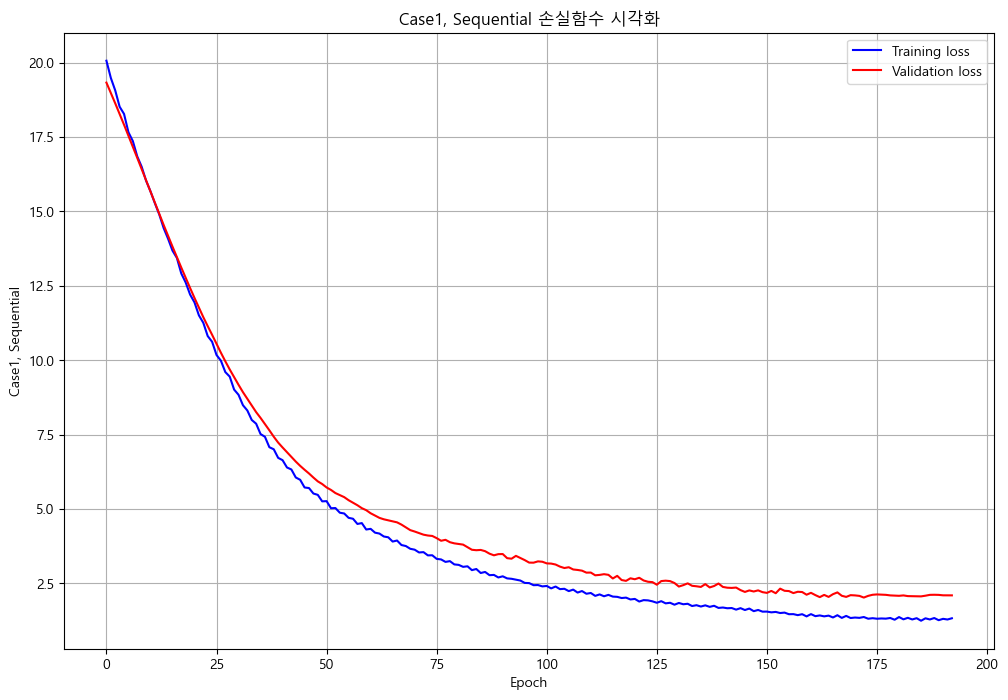

In [79]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case1_lstm_uni = Sequential()

case1_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case1_lstm_uni.add(BatchNormalization())
case1_lstm_uni.add(Dropout(0.3))

case1_lstm_uni.add(Dense(24, activation='relu'))
case1_lstm_uni.add(Dense(12))

case1_lstm_uni.compile(optimizer=optimizer, loss='mse')

case1_lstm_uni_history = case1_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case1_lstm_uni_history, "Case1, Sequential")

In [10]:
Y_hat_case1_uni = case1_lstm_uni.predict(x_test_multi)

Y_hat_case1_uni = Y_hat_case1_uni * case1_std[-1] + case1_mean[-1]

case1_lstm_uni.save("./output/case1_lstm_uni.h5")

1/1 [==============================] - 1s 827ms/step


---

Epoch 1/300
16/16 [==============================] - 7s 83ms/step - loss: 23.3165 - val_loss: 21.9520 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 19ms/step - loss: 22.1328 - val_loss: 21.1326 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 21.1200 - val_loss: 20.2745 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 20.1090 - val_loss: 19.3960 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 19.0919 - val_loss: 18.5139 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 18.1245 - val_loss: 17.6345 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 20ms/step - loss: 17.1996 - val_loss: 16.7625 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 16.3117 - val_loss: 15.9039 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 1.7248 - val_loss: 2.1795 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 16ms/step - loss: 1.7174 - val_loss: 2.1846 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6824 - val_loss: 2.0935 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 18ms/step - loss: 1.6840 - val_loss: 2.0621 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 18ms/step - loss: 1.6248 - val_loss: 2.0569 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 1.6355 - val_loss: 2.0493 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 18ms/step - loss: 1.5763 - val_loss: 1.9980 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 18ms/step - loss: 1.5798 - val_loss: 2.0267 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

Epoch 136/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8174 - val_loss: 1.3606 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8248 - val_loss: 1.3122 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 18ms/step - loss: 0.8100 - val_loss: 1.3668 - lr: 6.2500e-05
Epoch 139/300
16/16 [==============================] - 0s 17ms/step - loss: 0.8333 - val_loss: 1.3359 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 19ms/step - loss: 0.8183 - val_loss: 1.3515 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 19ms/step - loss: 0.8056 - val_loss: 1.3549 - lr: 6.2500e-05
Epoch 142/300
13/16 [=======================>......] - ETA: 0s - loss: 0.8236
Epoch 142: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 0s 17ms/step - loss: 0.8196 - val_loss: 1.3425 - lr: 6.2500e-05
Epoch 143/300
16/16 [====

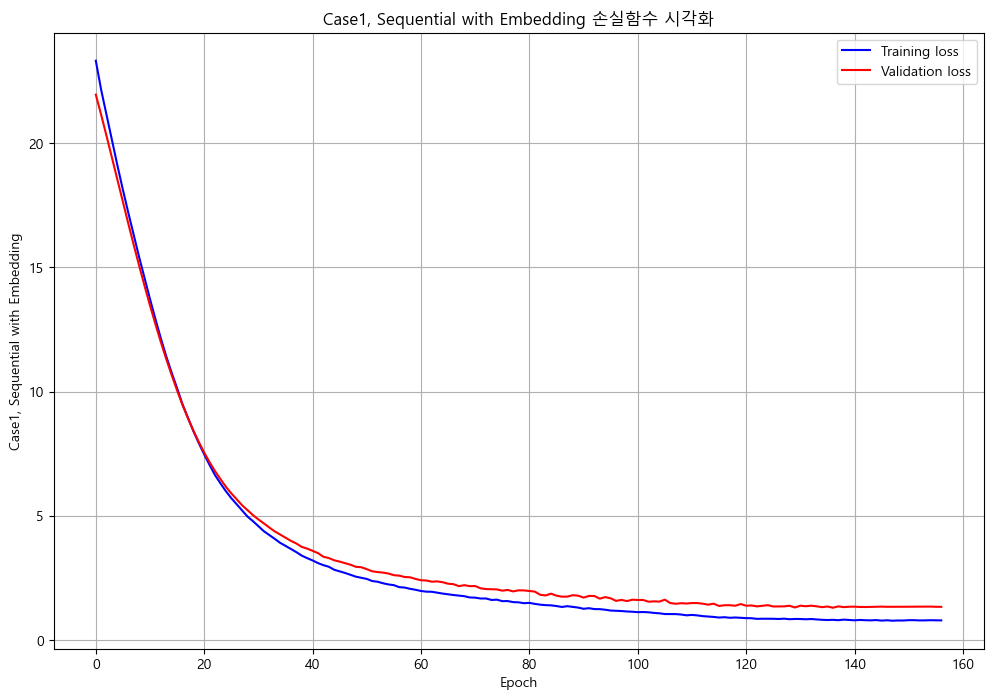

In [130]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_uni_label.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case1_uni_label_history = case1_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_uni_label_history, "Case1, One Way LSTM with Embedding")

In [132]:
Y_HAT_case1_uni = case1_uni_label.predict([x_test_multi, x_test_label])

1/1 [==============================] - 0s 26ms/step


### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 9s 118ms/step - loss: 55.6433 - val_loss: 53.2884 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 24ms/step - loss: 52.1775 - val_loss: 50.0137 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 25ms/step - loss: 48.6158 - val_loss: 46.6436 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 24ms/step - loss: 45.1854 - val_loss: 43.2821 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 24ms/step - loss: 41.7770 - val_loss: 39.9901 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 31ms/step - loss: 38.4680 - val_loss: 36.8017 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 22ms/step - loss: 35.2764 - val_loss: 33.7425 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 22ms/step - loss: 32.2576 - val_loss: 30.8275 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

16/16 [==============================] - 0s 25ms/step - loss: 0.8925 - val_loss: 1.4734 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 23ms/step - loss: 0.9000 - val_loss: 1.5140 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 26ms/step - loss: 0.8985 - val_loss: 1.4913 - lr: 5.0000e-04
Epoch 142/300
15/16 [===========================>..] - ETA: 0s - loss: 0.8934
Epoch 142: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
16/16 [==============================] - 0s 25ms/step - loss: 0.8933 - val_loss: 1.4583 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8441 - val_loss: 1.3963 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8322 - val_loss: 1.3299 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8069 - val_loss: 1.3071 - lr: 2.5000e-04
Epoch 146/300
16/16 [==================

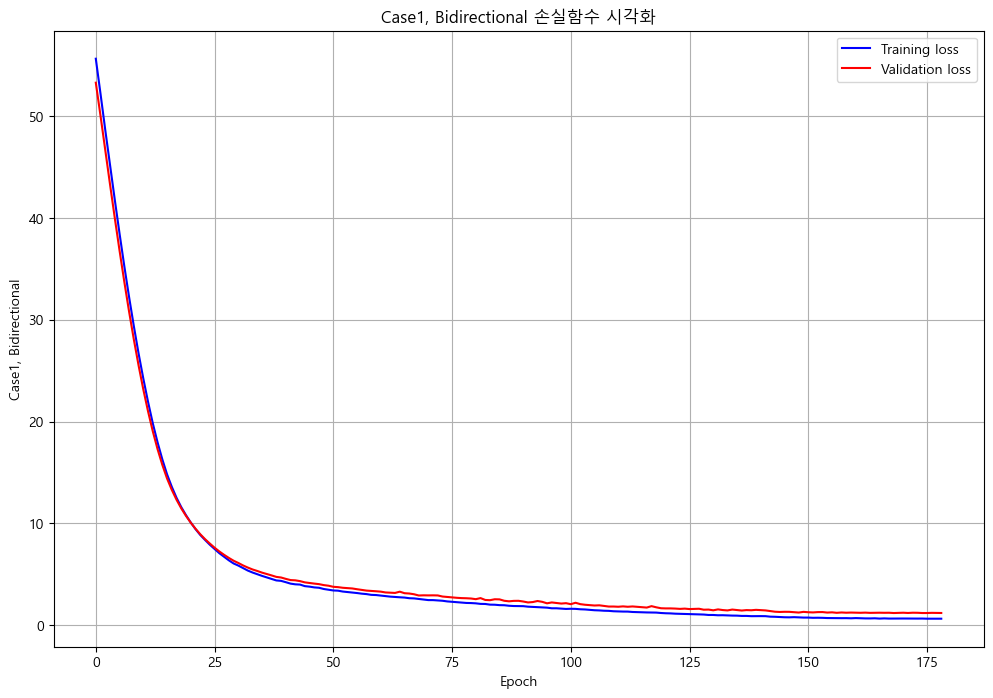

In [11]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case1_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case1_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case1_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case1_lstm_bi_history = case1_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case1_lstm_bi_history, "Case1, Bidirectional")

In [12]:
Y_hat_case1_bi = case1_lstm_bi.predict(x_test_multi)

Y_hat_case1_bi = Y_hat_case1_bi * case1_std[-1] + case1_mean[-1]

case1_lstm_bi.save("./output/case1_lstm_bi.h5")

1/1 [==============================] - 1s 1s/step


---

Epoch 1/300
16/16 [==============================] - 9s 127ms/step - loss: 55.8864 - val_loss: 53.4173 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 24ms/step - loss: 51.8903 - val_loss: 49.5964 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 47.9365 - val_loss: 45.7843 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 26ms/step - loss: 44.0724 - val_loss: 42.0753 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 28ms/step - loss: 40.3652 - val_loss: 38.5058 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 29ms/step - loss: 36.7795 - val_loss: 35.0980 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 26ms/step - loss: 33.3875 - val_loss: 31.8784 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 29ms/step - loss: 30.2992 - val_loss: 28.8493 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

16/16 [==============================] - 0s 30ms/step - loss: 2.3998 - val_loss: 2.8144 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 26ms/step - loss: 2.3702 - val_loss: 2.7368 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 29ms/step - loss: 2.3008 - val_loss: 2.6884 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 27ms/step - loss: 2.2523 - val_loss: 2.6548 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 26ms/step - loss: 2.2122 - val_loss: 2.7234 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 30ms/step - loss: 2.2073 - val_loss: 2.6371 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 30ms/step - loss: 2.1646 - val_loss: 2.6027 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 27ms/step - loss: 2.1338 - val_loss: 2.5999 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 25ms/step - 

16/16 [==============================] - 0s 27ms/step - loss: 0.9942 - val_loss: 1.5482 - lr: 6.2500e-05
Epoch 136/300
16/16 [==============================] - 0s 26ms/step - loss: 0.9931 - val_loss: 1.5432 - lr: 6.2500e-05
Epoch 137/300
16/16 [==============================] - ETA: 0s - loss: 0.9993
Epoch 137: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
16/16 [==============================] - 1s 32ms/step - loss: 0.9993 - val_loss: 1.5445 - lr: 6.2500e-05
Epoch 138/300
16/16 [==============================] - 0s 29ms/step - loss: 0.9842 - val_loss: 1.5658 - lr: 3.1250e-05
Epoch 139/300
16/16 [==============================] - 0s 26ms/step - loss: 0.9969 - val_loss: 1.5390 - lr: 3.1250e-05
Epoch 140/300
16/16 [==============================] - 0s 26ms/step - loss: 0.9825 - val_loss: 1.5261 - lr: 3.1250e-05
Epoch 141/300
16/16 [==============================] - 0s 28ms/step - loss: 0.9807 - val_loss: 1.5298 - lr: 3.1250e-05
Epoch 142/300
16/16 [==================

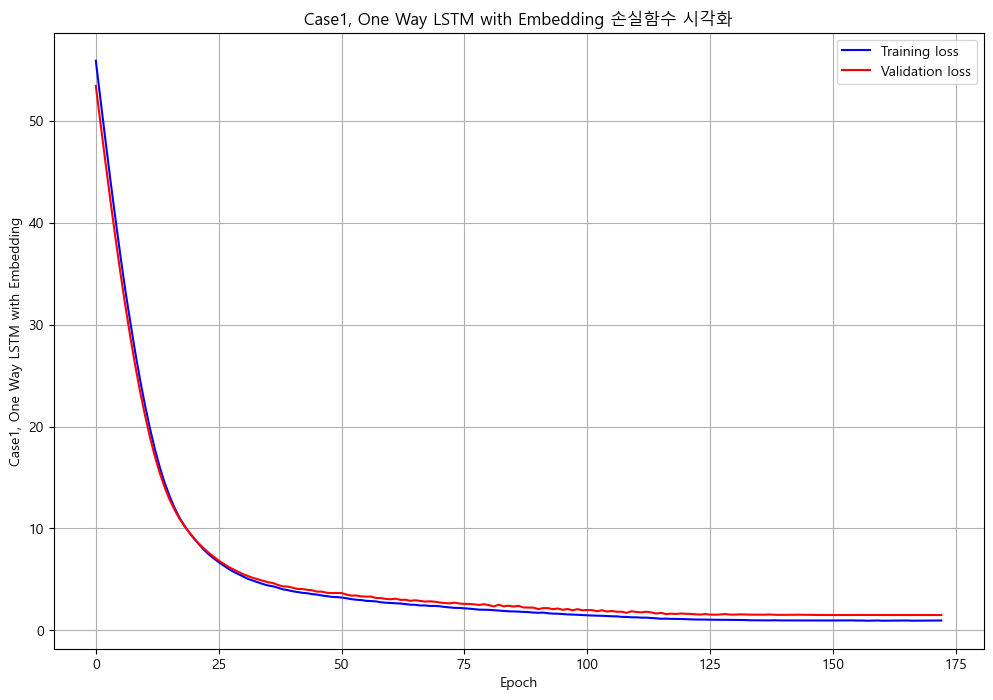

In [133]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case1_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case1_bi_label.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case1_bi_label_history = case1_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case1_bi_label_history, "Case1, Bidirectional LSTM with Embedding")

In [134]:
Y_HAT_case1_bi = case1_bi_label.predict([x_test_multi, x_test_label])

NameError: name 'case1_bi_label' is not defined

# Case2) WTIO, SETIO & 로그변환

## 데이터 전처리

### 부호 유지 로그 변환

In [137]:
case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case2_dts = case2_df.values
print(case2_dts.shape)

case2_label = case2_dts[ : , 4]
case2_dts = case2_dts[ : , [0, 1, 2, 3, 5]]

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))
print(case2_dts.shape)

(400, 6)
(400, 5)


In [139]:
# # case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']]
# case2_dts = case2_df.values

# case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))

### 데이터 분포 확인

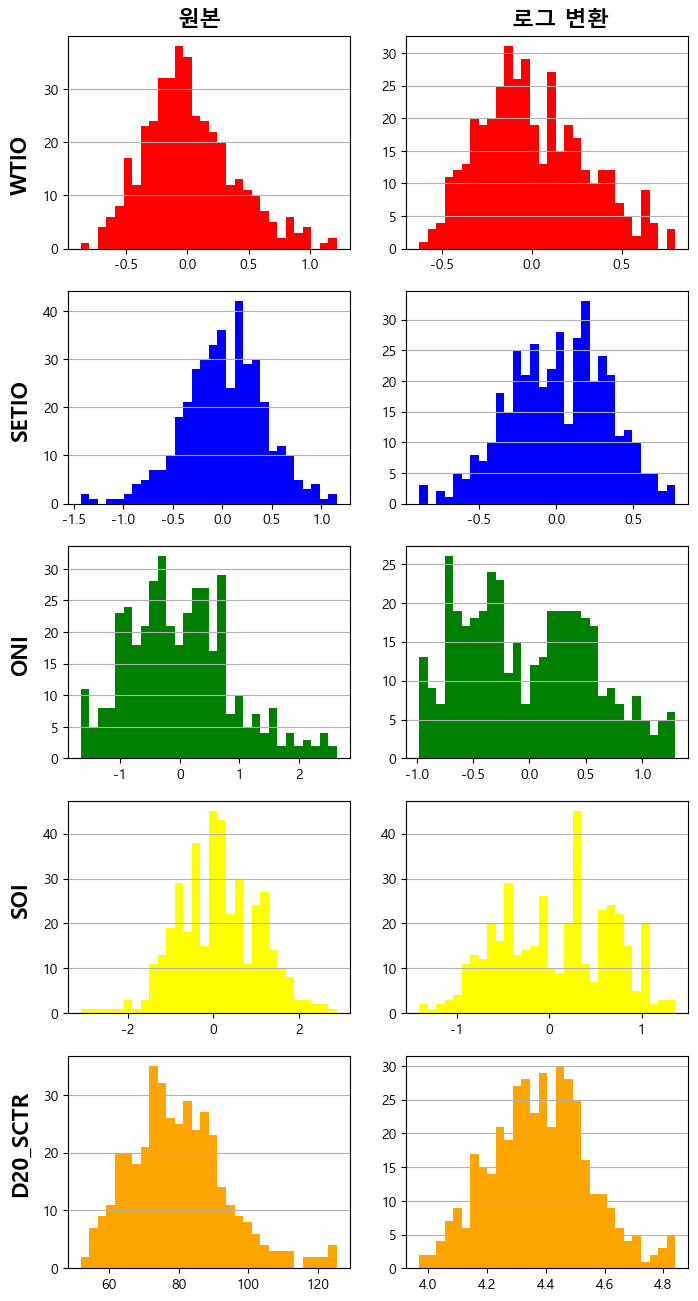

In [140]:
# fig, ax = plt.subplots(5, 2, figsize=(8, 16))

# i = 0

# colors = ["red", "blue", "green", "yellow", "orange"]

# for column in case2_df.columns:

#     ax[i][0].hist(case2_df[column], bins=30, label=column, color=colors[i])
#     ax[i][0].grid(axis = "y")
    
#     ax[i][1].hist(case2_dts[:, i], bins=30, label=column, color=colors[i])
#     ax[i][1].grid(axis = "y")

#     i += 1
    
# for j, col_title in enumerate(['원본', '로그 변환']):
#     fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
# for i, label in enumerate(['WTIO', 'SETIO', 'ONI', 'SOI', 'D20_SCTR']):
#     fig.text(0.08, 0.8 - i * 0.153, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')

## 데이터 분리

In [15]:
# # 학습 데이터
# x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# # 검증 데이터
# x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# # 테스트 데이터
# x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

# print(f"학습 데이터 형태: {x_train_multi.shape}")
# print(f"검증 데이터 형태: {x_val_multi.shape}")
# print(f"테스트 데이터 형태: {x_test_multi.shape}")

# print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
# print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
검증 데이터 형태: (56, 12, 5)
테스트 데이터 형태: (16, 12, 5)
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


In [ ]:
# BUFFER_SIZE = 100

# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [141]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case2_dts, case2_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

x_train_label = label_split(case2_label, 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

x_val_label = label_split(case2_label, TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case2_dts, case2_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

x_test_label = label_split(case2_label, TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"학습 타겟데이터 형태: {y_train_multi.shape}")
print(f"학습 라벨데이터 형태: {x_train_label.shape}")
print("--------------------------------")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"검증 타겟데이터 형태: {y_val_multi.shape}")
print(f"검증 라벨데이터 형태: {x_val_label.shape}")
print("--------------------------------")
print(f"테스트 데이터 형태: {x_test_multi.shape}")
print(f"테스트 타겟데이터 형태: {y_test_multi.shape}")
print(f"테스트 라벨데이터 형태: {x_test_label.shape}")
print("--------------------------------")
print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 5)
학습 타겟데이터 형태: (256, 12)
학습 라벨데이터 형태: (256, 12)
--------------------------------
검증 데이터 형태: (56, 12, 5)
검증 타겟데이터 형태: (56, 12)
검증 라벨데이터 형태: (56, 12)
--------------------------------
테스트 데이터 형태: (16, 12, 5)
테스트 타겟데이터 형태: (16, 12)
테스트 라벨데이터 형태: (16, 12)
--------------------------------
과거 데이터 윈도우 형태: (12, 5)
예측 목표 기간 형태: (12,)


## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 6s 71ms/step - loss: 35.6861 - val_loss: 36.8017 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 19ms/step - loss: 33.2637 - val_loss: 35.8929 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 30.9333 - val_loss: 34.7665 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 29.1088 - val_loss: 33.3098 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 26.9078 - val_loss: 31.8703 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 24.8555 - val_loss: 30.0924 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 22.9233 - val_loss: 27.9807 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 20ms/step - loss: 21.0891 - val_loss: 26.3991 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 17ms/step - loss: 0.9844 - val_loss: 0.7598 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9164 - val_loss: 0.7041 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9117 - val_loss: 0.7422 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9333 - val_loss: 0.7160 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 19ms/step - loss: 0.9326 - val_loss: 0.7072 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9408 - val_loss: 0.6772 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9025 - val_loss: 0.6641 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9544 - val_loss: 0.6334 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 17ms

16/16 [==============================] - 0s 17ms/step - loss: 0.6988 - val_loss: 0.4292 - lr: 1.0000e-06
Epoch 267/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6705 - val_loss: 0.4286 - lr: 1.0000e-06
Epoch 268/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6649 - val_loss: 0.4289 - lr: 1.0000e-06
Epoch 269/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6580 - val_loss: 0.4273 - lr: 1.0000e-06
Epoch 270/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6478 - val_loss: 0.4287 - lr: 1.0000e-06
Epoch 271/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6969 - val_loss: 0.4310 - lr: 1.0000e-06
Epoch 272/300
16/16 [==============================] - 0s 19ms/step - loss: 0.6621 - val_loss: 0.4315 - lr: 1.0000e-06
Epoch 273/300
16/16 [==============================] - 0s 17ms/step - loss: 0.7155 - val_loss: 0.4313 - lr: 1.0000e-06
Epoch 274/300
16/16 [==============================] - 0s 17ms

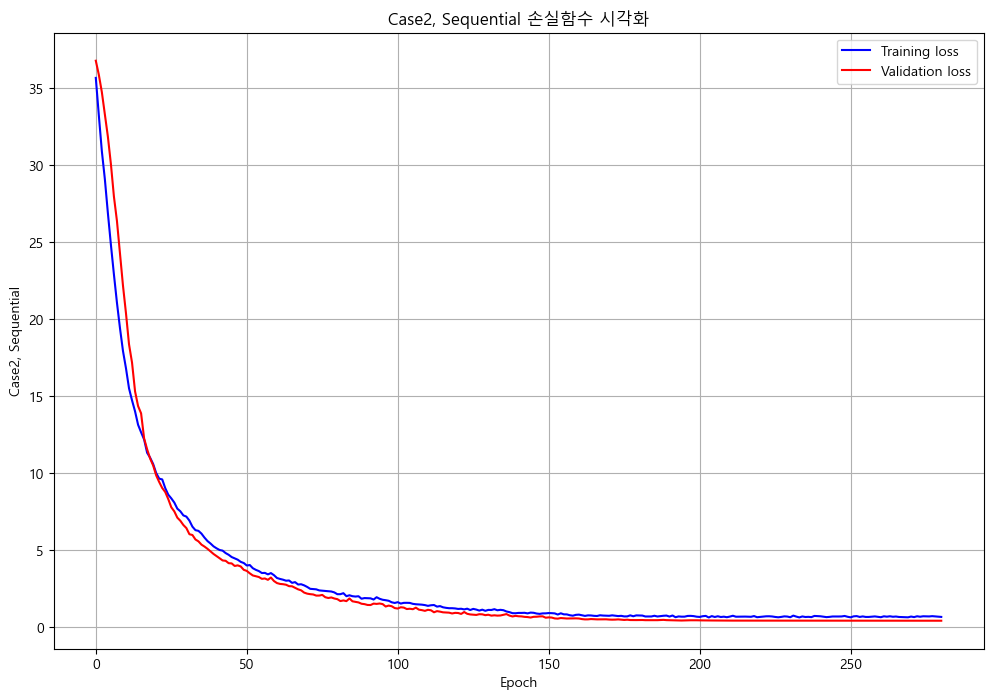

In [17]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case2_lstm_uni = Sequential()

case2_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case2_lstm_uni.add(BatchNormalization())
case2_lstm_uni.add(Dropout(0.3))

case2_lstm_uni.add(Dense(24, activation='relu'))
case2_lstm_uni.add(Dense(12))

case2_lstm_uni.compile(optimizer=optimizer, loss='mse')

case2_lstm_uni_history = case2_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case2_lstm_uni_history, "Case2, Sequential")

In [18]:
Y_hat_case2_uni = case2_lstm_uni.predict(x_test_multi)

Y_hat_case2_uni = np.sign(Y_hat_case2_uni) * (np.expm1(np.abs(Y_hat_case2_uni)))

case2_lstm_uni.save("./output/case2_lstm_uni.h5")

1/1 [==============================] - 1s 845ms/step


----

Epoch 1/300
16/16 [==============================] - 6s 81ms/step - loss: 40.2522 - val_loss: 40.0695 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 17ms/step - loss: 37.8481 - val_loss: 39.0687 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 17ms/step - loss: 35.5702 - val_loss: 37.9285 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 33.7566 - val_loss: 36.5261 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 31.5838 - val_loss: 35.0242 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 18ms/step - loss: 29.4336 - val_loss: 33.2184 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 27.4672 - val_loss: 31.2587 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 17ms/step - loss: 25.2713 - val_loss: 28.9774 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 16ms/step - loss: 2.6583 - val_loss: 2.4558 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.6218 - val_loss: 2.3358 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5327 - val_loss: 2.2082 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.4685 - val_loss: 2.2399 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 21ms/step - loss: 2.4530 - val_loss: 2.1001 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 16ms/step - loss: 2.3541 - val_loss: 2.1365 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 18ms/step - loss: 2.3520 - val_loss: 2.0985 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 17ms/step - loss: 2.2952 - val_loss: 2.2127 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 18ms/step - 

16/16 [==============================] - 0s 17ms/step - loss: 1.0164 - val_loss: 0.8009 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 18ms/step - loss: 1.0516 - val_loss: 0.8007 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9988 - val_loss: 0.7405 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0148 - val_loss: 0.7733 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 19ms/step - loss: 1.0318 - val_loss: 0.7456 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 18ms/step - loss: 0.9820 - val_loss: 0.7168 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 17ms/step - loss: 0.9798 - val_loss: 0.7030 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 17ms/step - loss: 1.0122 - val_loss: 0.7043 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 16ms

16/16 [==============================] - 0s 14ms/step - loss: 0.7415 - val_loss: 0.5086 - lr: 3.1250e-05
Epoch 204/300
14/16 [=========================>....] - ETA: 0s - loss: 0.7164
Epoch 204: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 16ms/step - loss: 0.7106 - val_loss: 0.5054 - lr: 3.1250e-05
Epoch 205/300
16/16 [==============================] - 0s 21ms/step - loss: 0.6865 - val_loss: 0.4919 - lr: 1.5625e-05
Epoch 206/300
16/16 [==============================] - 0s 21ms/step - loss: 0.7222 - val_loss: 0.4854 - lr: 1.5625e-05
Epoch 207/300
16/16 [==============================] - 0s 20ms/step - loss: 0.7480 - val_loss: 0.4835 - lr: 1.5625e-05
Epoch 208/300
16/16 [==============================] - 0s 19ms/step - loss: 0.6625 - val_loss: 0.4848 - lr: 1.5625e-05
Epoch 209/300
16/16 [==============================] - 0s 18ms/step - loss: 0.7616 - val_loss: 0.4818 - lr: 1.5625e-05
Epoch 210/300
16/16 [=================

16/16 [==============================] - 0s 16ms/step - loss: 0.7251 - val_loss: 0.4680 - lr: 1.0000e-06
Epoch 267/300
16/16 [==============================] - 0s 16ms/step - loss: 0.6719 - val_loss: 0.4688 - lr: 1.0000e-06
Epoch 268/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6783 - val_loss: 0.4697 - lr: 1.0000e-06
Epoch 269/300
16/16 [==============================] - 0s 17ms/step - loss: 0.6911 - val_loss: 0.4675 - lr: 1.0000e-06
Epoch 270/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6916 - val_loss: 0.4685 - lr: 1.0000e-06
Epoch 271/300
16/16 [==============================] - 0s 18ms/step - loss: 0.6725 - val_loss: 0.4684 - lr: 1.0000e-06
Epoch 272/300
16/16 [==============================] - 0s 21ms/step - loss: 0.6904 - val_loss: 0.4654 - lr: 1.0000e-06
Epoch 273/300
16/16 [==============================] - 0s 21ms/step - loss: 0.7286 - val_loss: 0.4645 - lr: 1.0000e-06
Epoch 274/300
16/16 [==============================] - 0s 18ms

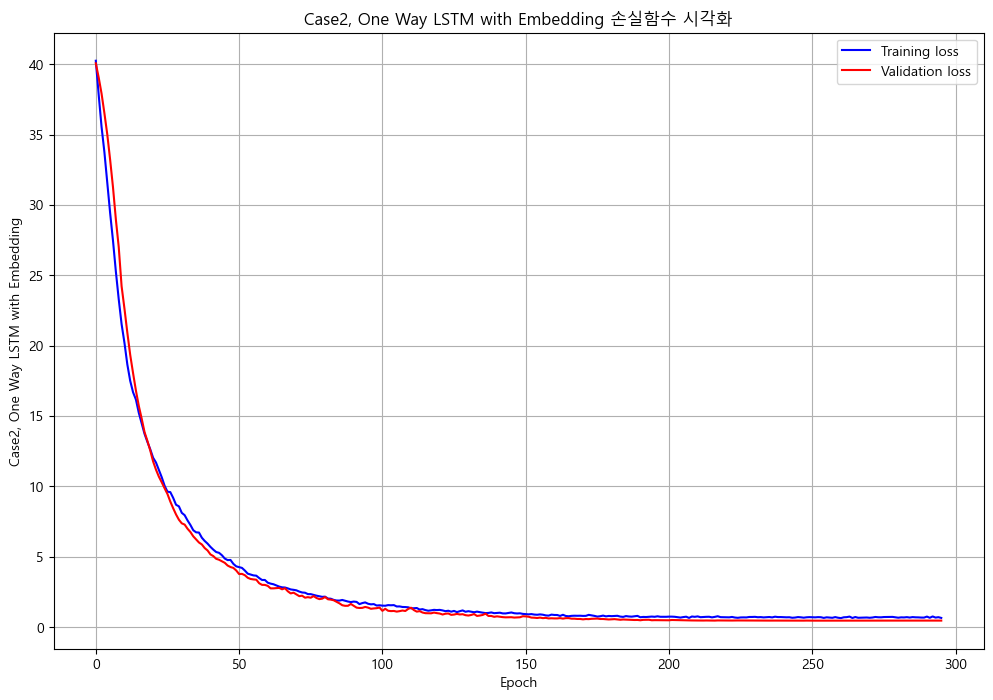

In [143]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = LSTM(128, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = LSTM(64, return_sequences=True,
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_uni_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_uni_label.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case2_uni_label_history = case2_uni_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_uni_label_history, "Case2, One Way LSTM with Embedding")

In [148]:
Y_HAT_case2_uni = case2_uni_label.predict([x_test_multi, x_test_label])

Y_HAT_case2_uni = np.sign(Y_HAT_case2_uni) * (np.expm1(np.abs(Y_HAT_case2_uni)))

1/1 [==============================] - 0s 27ms/step


### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 9s 114ms/step - loss: 73.5941 - val_loss: 73.0389 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 25ms/step - loss: 69.8995 - val_loss: 70.7183 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 66.1485 - val_loss: 68.0992 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 27ms/step - loss: 62.4345 - val_loss: 65.3950 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 24ms/step - loss: 58.6350 - val_loss: 62.5085 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 25ms/step - loss: 54.5808 - val_loss: 59.4115 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 22ms/step - loss: 50.8529 - val_loss: 56.1989 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 22ms/step - loss: 47.1877 - val_loss: 53.0687 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

Epoch 70/300
16/16 [==============================] - 0s 28ms/step - loss: 4.0597 - val_loss: 4.7826 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 30ms/step - loss: 4.0781 - val_loss: 4.2299 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 28ms/step - loss: 3.9911 - val_loss: 3.9178 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 29ms/step - loss: 4.0768 - val_loss: 3.9240 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 28ms/step - loss: 3.8542 - val_loss: 4.1097 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 29ms/step - loss: 3.7645 - val_loss: 4.1689 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 1s 32ms/step - loss: 3.6861 - val_loss: 3.9125 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 1s 34ms/step - loss: 3.6118 - val_loss: 3.7268 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s

Epoch 138/300
16/16 [==============================] - 0s 28ms/step - loss: 1.6252 - val_loss: 1.4659 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 30ms/step - loss: 1.6665 - val_loss: 1.4031 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 28ms/step - loss: 1.5917 - val_loss: 1.3350 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 25ms/step - loss: 1.5983 - val_loss: 1.3090 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 24ms/step - loss: 1.6401 - val_loss: 1.3149 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 27ms/step - loss: 1.6168 - val_loss: 1.3372 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 27ms/step - loss: 1.6079 - val_loss: 1.3492 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 26ms/step - loss: 1.5505 - val_loss: 1.2539 - lr: 2.5000e-04
Epoch 146/300
16/16 [===========================

Epoch 206/300
16/16 [==============================] - 1s 31ms/step - loss: 1.0004 - val_loss: 0.7720 - lr: 1.2500e-04
Epoch 207/300
16/16 [==============================] - 1s 33ms/step - loss: 0.9678 - val_loss: 0.7528 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 1s 31ms/step - loss: 0.9516 - val_loss: 0.7413 - lr: 1.2500e-04
Epoch 209/300
16/16 [==============================] - 0s 27ms/step - loss: 1.0103 - val_loss: 0.7419 - lr: 1.2500e-04
Epoch 210/300
16/16 [==============================] - 0s 31ms/step - loss: 0.9350 - val_loss: 0.7259 - lr: 1.2500e-04
Epoch 211/300
16/16 [==============================] - 0s 27ms/step - loss: 0.9816 - val_loss: 0.7065 - lr: 1.2500e-04
Epoch 212/300
16/16 [==============================] - 1s 31ms/step - loss: 0.9447 - val_loss: 0.7044 - lr: 1.2500e-04
Epoch 213/300
16/16 [==============================] - 0s 31ms/step - loss: 0.9643 - val_loss: 0.7017 - lr: 1.2500e-04
Epoch 214/300
16/16 [===========================

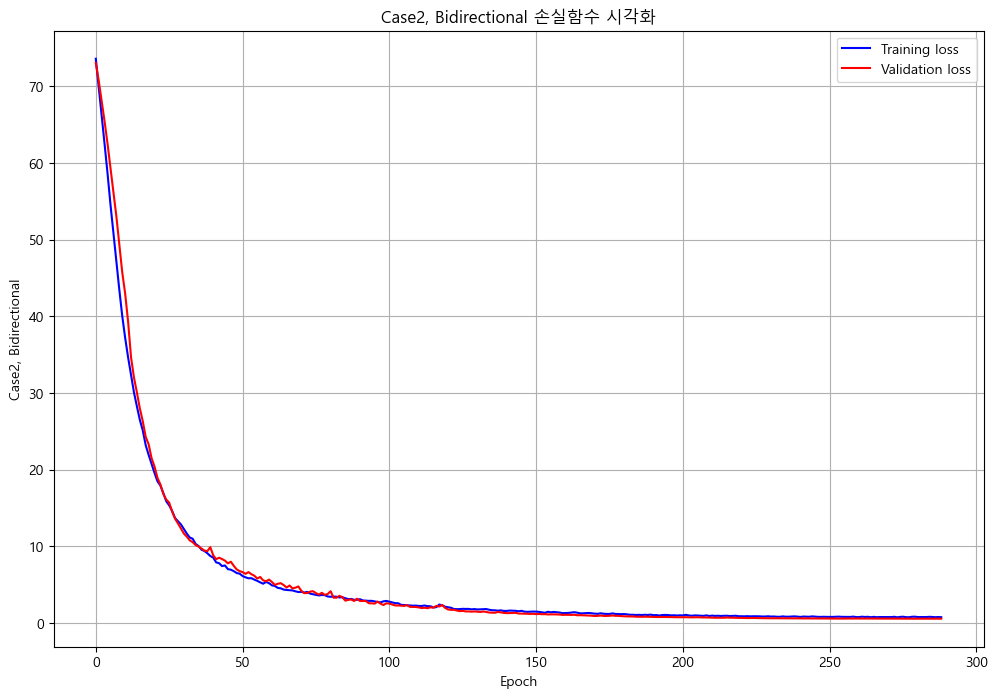

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case2_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case2_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case2_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case2_lstm_bi_history = case2_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case2_lstm_bi_history, "Case2, Bidirectional")

In [20]:
Y_hat_case2_bi = case2_lstm_bi.predict(x_test_multi)

Y_hat_case2_bi = np.sign(Y_hat_case2_bi) * (np.expm1(np.abs(Y_hat_case2_bi)))

case2_lstm_bi.save("./output/case2_lstm_bi.h5")

1/1 [==============================] - 2s 2s/step


----

Epoch 1/300
16/16 [==============================] - 9s 121ms/step - loss: 74.5924 - val_loss: 73.4815 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 27ms/step - loss: 70.9754 - val_loss: 70.8914 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 28ms/step - loss: 67.1441 - val_loss: 68.0934 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 23ms/step - loss: 63.3893 - val_loss: 65.2235 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 23ms/step - loss: 59.6520 - val_loss: 62.4650 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 22ms/step - loss: 55.9603 - val_loss: 59.2915 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 25ms/step - loss: 52.4895 - val_loss: 55.8135 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 23ms/step - loss: 48.7191 - val_loss: 52.4202 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

Epoch 70/300
16/16 [==============================] - 0s 24ms/step - loss: 3.7028 - val_loss: 3.6528 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 23ms/step - loss: 3.5450 - val_loss: 3.2071 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 22ms/step - loss: 3.3728 - val_loss: 3.5175 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 24ms/step - loss: 3.3743 - val_loss: 3.3985 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 22ms/step - loss: 3.3057 - val_loss: 3.2459 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 22ms/step - loss: 3.2474 - val_loss: 2.9883 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 29ms/step - loss: 3.2665 - val_loss: 3.8819 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 25ms/step - loss: 3.2849 - val_loss: 2.7749 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 1s

16/16 [==============================] - 0s 25ms/step - loss: 1.1702 - val_loss: 0.9624 - lr: 5.0000e-04
Epoch 140/300
16/16 [==============================] - 0s 25ms/step - loss: 1.1393 - val_loss: 0.9356 - lr: 5.0000e-04
Epoch 141/300
16/16 [==============================] - 0s 24ms/step - loss: 1.1145 - val_loss: 0.9542 - lr: 5.0000e-04
Epoch 142/300
16/16 [==============================] - 0s 26ms/step - loss: 1.1616 - val_loss: 0.8628 - lr: 5.0000e-04
Epoch 143/300
16/16 [==============================] - 0s 24ms/step - loss: 1.1390 - val_loss: 0.8558 - lr: 5.0000e-04
Epoch 144/300
16/16 [==============================] - 0s 24ms/step - loss: 1.1260 - val_loss: 0.8733 - lr: 5.0000e-04
Epoch 145/300
16/16 [==============================] - 0s 23ms/step - loss: 1.0383 - val_loss: 0.9030 - lr: 5.0000e-04
Epoch 146/300
16/16 [==============================] - 0s 27ms/step - loss: 1.0920 - val_loss: 0.8589 - lr: 5.0000e-04
Epoch 147/300
16/16 [==============================] - 0s 24ms

16/16 [==============================] - 0s 30ms/step - loss: 0.5787 - val_loss: 0.3207 - lr: 1.2500e-04
Epoch 206/300
16/16 [==============================] - 0s 31ms/step - loss: 0.4937 - val_loss: 0.3241 - lr: 1.2500e-04
Epoch 207/300
16/16 [==============================] - ETA: 0s - loss: 0.5081
Epoch 207: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 28ms/step - loss: 0.5081 - val_loss: 0.3195 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 0s 24ms/step - loss: 0.4541 - val_loss: 0.3059 - lr: 6.2500e-05
Epoch 209/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5103 - val_loss: 0.3052 - lr: 6.2500e-05
Epoch 210/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5049 - val_loss: 0.3125 - lr: 6.2500e-05
Epoch 211/300
16/16 [==============================] - 0s 23ms/step - loss: 0.5001 - val_loss: 0.3145 - lr: 6.2500e-05
Epoch 212/300
16/16 [===================

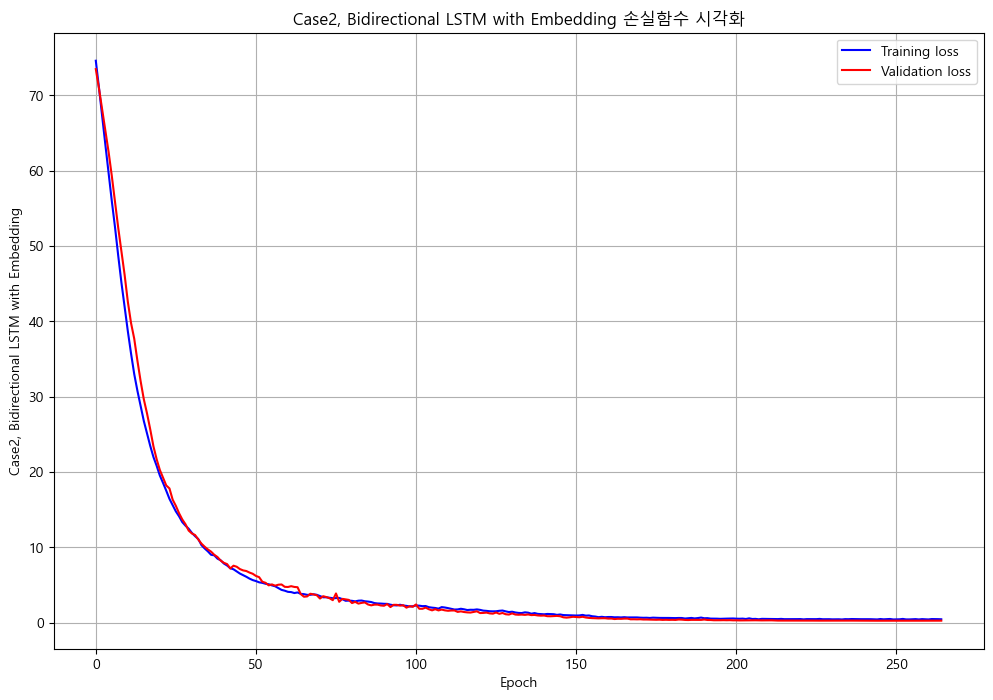

In [146]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization, Input, Embedding, Concatenate, Attention, Bidirectional
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 범주형 변수 설정
num_categories = 3
embedding_dim = 5

# 옵티마이저 및 콜백 설정
optimizer = Adam(learning_rate=initial_lr)
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# 모델 정의
numerical_input = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))
categorical_input = Input(shape=(x_train_label.shape[1], ))

# 임베딩 레이어
embedding = Embedding(input_dim=num_categories, output_dim=embedding_dim)(categorical_input)

# 입력 결합
combined_input = Concatenate(axis=-1)([numerical_input, embedding])

x = Bidirectional(LSTM(128, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(combined_input)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                   kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                   bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu')(x)
output = Dense(12)(x)

case2_bi_label = Model(inputs=[numerical_input, categorical_input], outputs=output)
case2_bi_label.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case2_bi_label_history = case2_bi_label.fit(
    # 수치형 데이터와 범주형 데이터 분리    
    [x_train_multi, x_train_label],  
    y_train_multi,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    validation_data=([x_val_multi, x_val_label], y_val_multi),
    callbacks=[lr_restart, early_stop]
)

# 학습 결과 시각화
plot_train_history(case2_bi_label_history, "Case2, Bidirectional LSTM with Embedding")

In [164]:
x_test_multi.shape

(16, 12, 5)

In [165]:
x_test_label.shape

(16, 12)

In [149]:
Y_HAT_case2_bi = case2_bi_label.predict([x_test_multi, x_test_label])

Y_HAT_case2_bi = np.sign(Y_HAT_case2_bi) * (np.expm1(np.abs(Y_HAT_case2_bi)))

1/1 [==============================] - 1s 1s/step


In [ ]:
case2_df = data[['WTIO', 'SETIO', 'ONI', 'SOI', 'ENSO', 'D20_SCTR']]

case2_dts = case2_df.values
print(case2_dts.shape)

case2_label = case2_dts[ : , 4]
case2_dts = case2_dts[ : , [0, 1, 2, 3, 5]]

case2_dts = np.sign(case2_dts) * np.log1p(np.abs(case2_dts))
print(case2_dts.shape)

In [175]:
X_compare1_log = case2_dts[374 : 386, :]
X_compare1_log_label = case2_label[374 : 386]
X_compare1_log = np.reshape(X_compare1_log, (1, 12, 5))
X_compare1_log_label = np.reshape(X_compare1_log_label, (1, 12))

Y_compare1_log = case2_dts[387 : 399, -1]

In [178]:
case2_bi_label.predict([X_compare1_log, X_compare1_log_label])

1/1 [==============================] - 0s 30ms/step


array([[4.0805664, 4.133436 , 3.9041128, 4.274154 , 4.075513 , 4.2746735,
        3.9272654, 4.181655 , 3.9515476, 4.0637836, 3.9540148, 3.942725 ]],
      dtype=float32)

# Case3) DMI & 표준화

## 데이터 전처리

In [21]:
case3_df = data[['DMI', 'ONI', 'SOI', 'D20_SCTR']]

case3_dts = case3_df.values

case3_mean = case3_dts.mean(axis=0)
case3_std = case3_dts.std(axis=0)
case3_dts = (case3_dts-case3_mean)/case3_std

## 데이터 분리

In [22]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case3_dts, case3_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case3_dts, case3_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
검증 데이터 형태: (56, 12, 4)
테스트 데이터 형태: (16, 12, 4)
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


In [23]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 8s 114ms/step - loss: 19.1797 - val_loss: 18.2144 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 23ms/step - loss: 18.2310 - val_loss: 17.5331 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 17.3887 - val_loss: 16.8223 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 26ms/step - loss: 16.5565 - val_loss: 16.0978 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 25ms/step - loss: 15.7539 - val_loss: 15.3737 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 29ms/step - loss: 14.9686 - val_loss: 14.6516 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 26ms/step - loss: 14.2271 - val_loss: 13.9440 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 26ms/step - loss: 13.4567 - val_loss: 13.2478 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

Epoch 135/300
16/16 [==============================] - 0s 19ms/step - loss: 0.8616 - val_loss: 1.5166 - lr: 3.1250e-05
Epoch 136/300
16/16 [==============================] - 0s 23ms/step - loss: 0.8575 - val_loss: 1.5341 - lr: 3.1250e-05
Epoch 137/300
16/16 [==============================] - 0s 26ms/step - loss: 0.8552 - val_loss: 1.5201 - lr: 3.1250e-05
Epoch 138/300
16/16 [==============================] - 1s 32ms/step - loss: 0.8603 - val_loss: 1.5389 - lr: 3.1250e-05
Epoch 139/300
15/16 [===========================>..] - ETA: 0s - loss: 0.8618
Epoch 139: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
16/16 [==============================] - 0s 23ms/step - loss: 0.8570 - val_loss: 1.5134 - lr: 3.1250e-05
Epoch 140/300
16/16 [==============================] - 0s 20ms/step - loss: 0.8500 - val_loss: 1.5224 - lr: 1.5625e-05
Epoch 141/300
16/16 [==============================] - 0s 19ms/step - loss: 0.8458 - val_loss: 1.5317 - lr: 1.5625e-05
Epoch 142/300
16/16 [===

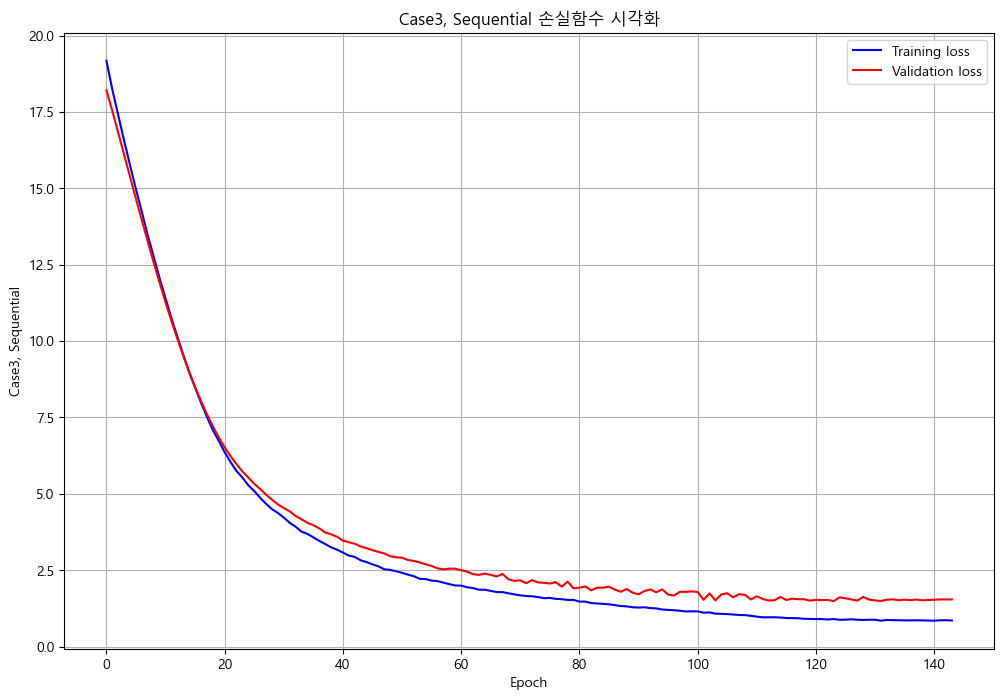

In [24]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case3_lstm_uni = Sequential()

case3_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case3_lstm_uni.add(BatchNormalization())
case3_lstm_uni.add(Dropout(0.3))

case3_lstm_uni.add(Dense(24, activation='relu'))
case3_lstm_uni.add(Dense(12))

case3_lstm_uni.compile(optimizer=optimizer, loss='mse')

case3_lstm_uni_history = case3_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case3_lstm_uni_history, "Case3, Sequential")

In [25]:
# 리트레이싱 발생
Y_hat_case3_uni = case3_lstm_uni.predict(x_test_multi)

Y_hat_case3_uni = Y_hat_case3_uni * case3_std[-1] + case3_mean[-1]

case3_lstm_uni.save("./output/case3_lstm_uni.h5")

1/1 [==============================] - 1s 1s/step


### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 11s 135ms/step - loss: 55.8939 - val_loss: 53.4877 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 24ms/step - loss: 52.6949 - val_loss: 50.5163 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 26ms/step - loss: 49.4652 - val_loss: 47.4167 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 23ms/step - loss: 46.1282 - val_loss: 44.2923 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 31ms/step - loss: 42.9601 - val_loss: 41.1857 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 1s 38ms/step - loss: 39.7978 - val_loss: 38.1438 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 29ms/step - loss: 36.7260 - val_loss: 35.1995 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 24ms/step - loss: 33.7992 - val_loss: 32.3801 - lr: 5.0000e-04
Epoch 9/300
16/16 [===========================

Epoch 137/300
16/16 [==============================] - 0s 25ms/step - loss: 1.0597 - val_loss: 1.6550 - lr: 1.2500e-04
Epoch 138/300
15/16 [===========================>..] - ETA: 0s - loss: 1.0669
Epoch 138: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
16/16 [==============================] - 0s 26ms/step - loss: 1.0611 - val_loss: 1.6760 - lr: 1.2500e-04
Epoch 139/300
16/16 [==============================] - 0s 28ms/step - loss: 1.0575 - val_loss: 1.6585 - lr: 6.2500e-05
Epoch 140/300
16/16 [==============================] - 0s 27ms/step - loss: 1.0618 - val_loss: 1.6425 - lr: 6.2500e-05
Epoch 141/300
16/16 [==============================] - 0s 31ms/step - loss: 1.0563 - val_loss: 1.6305 - lr: 6.2500e-05
Epoch 142/300
16/16 [==============================] - 0s 31ms/step - loss: 1.0501 - val_loss: 1.6502 - lr: 6.2500e-05
Epoch 143/300
16/16 [==============================] - ETA: 0s - loss: 1.0513
Epoch 143: ReduceLROnPlateau reducing learning rate to 3.1250001484

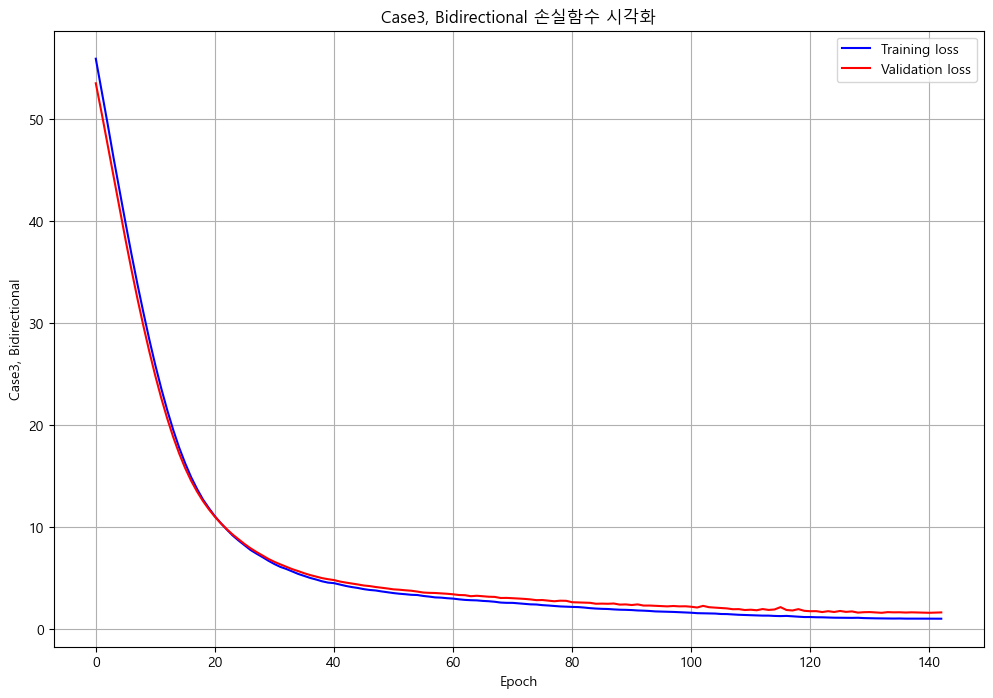

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case3_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case3_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case3_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case3_lstm_bi_history = case3_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case3_lstm_bi_history, "Case3, Bidirectional")

In [27]:
Y_hat_case3_bi = case3_lstm_bi.predict(x_test_multi)

Y_hat_case3_bi = Y_hat_case3_bi * case3_std[-1] + case3_mean[-1]

case3_lstm_bi.save("./output/case3_lstm_bi.h5")

1/1 [==============================] - 2s 2s/step


# Case4) DMI & 로그 변환

## 데이터 전처리

### 부호 유지 로그 변환

In [28]:
case4_df = data[['DMI', 'ONI', 'SOI', 'D20_SCTR']]
case4_dts = case4_df.values

case4_dts = np.sign(case4_dts) * np.log1p(np.abs(case4_dts))

### 데이터 분포 확인

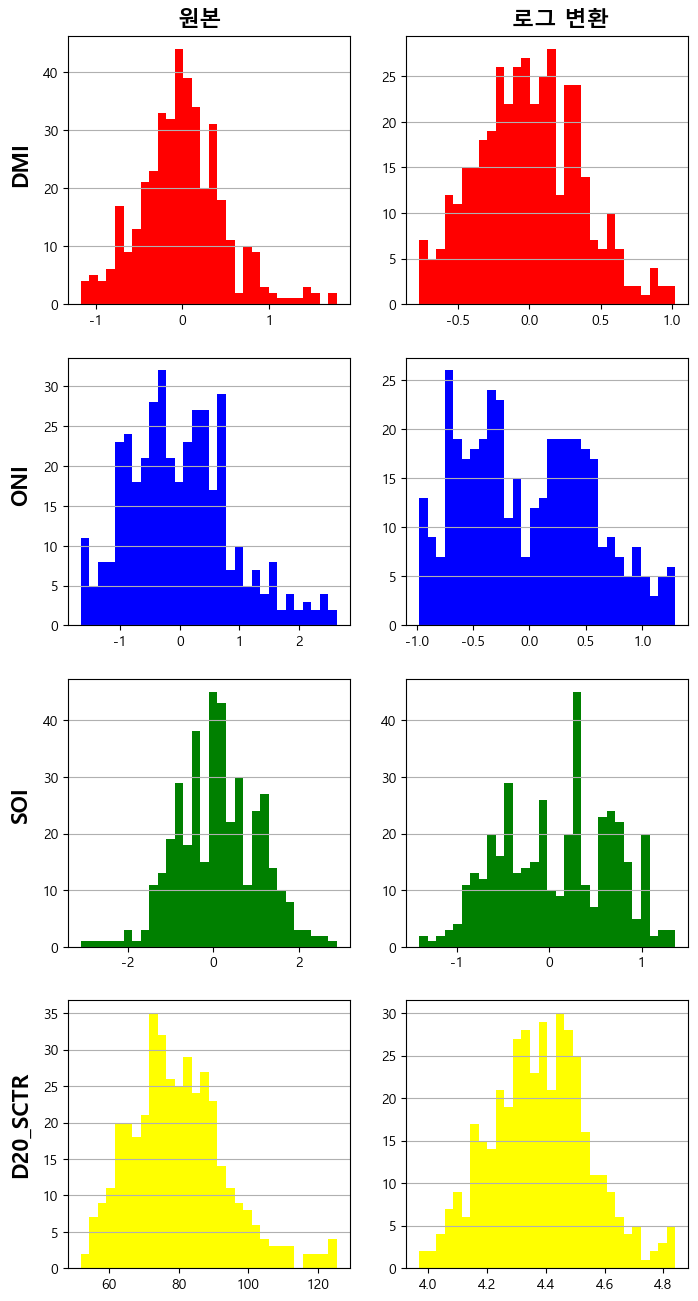

In [29]:
fig, ax = plt.subplots(4, 2, figsize=(8, 16))

i = 0

colors = ["red", "blue", "green", "yellow"]

for column in case4_df.columns:

    ax[i][0].hist(case4_df[column], bins=30, label=column, color=colors[i])
    ax[i][0].grid(axis = "y")
    
    ax[i][1].hist(case4_dts[:, i], bins=30, label=column, color=colors[i])
    ax[i][1].grid(axis = "y")

    i += 1
    
for j, col_title in enumerate(['원본', '로그 변환']):
    fig.text(0.29 + j * 0.45, 0.89, col_title, ha='center', va='center', fontsize=16, fontweight='bold')
    
for i, label in enumerate(['DMI', 'ONI', 'SOI', 'D20_SCTR']):
    fig.text(0.08, 0.8 - i * 0.2, label, va='center', ha='right', fontsize=16, rotation=90, fontweight='bold')

## 데이터 분리

In [30]:
# 학습 데이터
x_train_multi, y_train_multi = multivariate_data(case4_dts, case4_dts[:, -1], 0, TRAIN_SPLIT - future_target, past_history, future_target, STEP)

# 검증 데이터
x_val_multi, y_val_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT, TRAIN_SPLIT + VAL_SPLIT - future_target, past_history, future_target, STEP)

# 테스트 데이터
x_test_multi, y_test_multi = multivariate_data(case4_dts, case4_dts[:, -1], TRAIN_SPLIT + VAL_SPLIT, None, past_history, future_target, STEP)

print(f"학습 데이터 형태: {x_train_multi.shape}")
print(f"검증 데이터 형태: {x_val_multi.shape}")
print(f"테스트 데이터 형태: {x_test_multi.shape}")

print('과거 데이터 윈도우 형태: {}'.format(x_train_multi[0].shape))
print('예측 목표 기간 형태: {}'.format(y_train_multi[0].shape))

학습 데이터 형태: (256, 12, 4)
검증 데이터 형태: (56, 12, 4)
테스트 데이터 형태: (16, 12, 4)
과거 데이터 윈도우 형태: (12, 4)
예측 목표 기간 형태: (12,)


In [31]:
BUFFER_SIZE = 100

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))

train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

## 모델 학습

### 단방향 LSTM

Epoch 1/300
16/16 [==============================] - 7s 75ms/step - loss: 38.1804 - val_loss: 36.6670 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 18ms/step - loss: 35.5710 - val_loss: 36.1186 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 18ms/step - loss: 33.6865 - val_loss: 35.2536 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 18ms/step - loss: 31.9416 - val_loss: 34.1526 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 18ms/step - loss: 30.2469 - val_loss: 33.0022 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 19ms/step - loss: 28.2359 - val_loss: 31.6588 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 18ms/step - loss: 26.0774 - val_loss: 30.1782 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 0s 20ms/step - loss: 23.8027 - val_loss: 28.5161 - lr: 5.0000e-04
Epoch 9/300
16/16 [=============================

16/16 [==============================] - 0s 18ms/step - loss: 2.9850 - val_loss: 2.5350 - lr: 5.0000e-04
Epoch 71/300
16/16 [==============================] - 0s 17ms/step - loss: 2.9501 - val_loss: 2.4493 - lr: 5.0000e-04
Epoch 72/300
16/16 [==============================] - 0s 17ms/step - loss: 2.7874 - val_loss: 2.3882 - lr: 5.0000e-04
Epoch 73/300
16/16 [==============================] - 0s 17ms/step - loss: 2.7507 - val_loss: 2.2671 - lr: 5.0000e-04
Epoch 74/300
16/16 [==============================] - 0s 17ms/step - loss: 2.6795 - val_loss: 2.2342 - lr: 5.0000e-04
Epoch 75/300
16/16 [==============================] - 0s 17ms/step - loss: 2.5898 - val_loss: 2.1677 - lr: 5.0000e-04
Epoch 76/300
16/16 [==============================] - 0s 17ms/step - loss: 2.7183 - val_loss: 2.3149 - lr: 5.0000e-04
Epoch 77/300
16/16 [==============================] - 0s 18ms/step - loss: 2.5595 - val_loss: 2.1467 - lr: 5.0000e-04
Epoch 78/300
16/16 [==============================] - 0s 17ms/step - 

Epoch 205/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4503 - val_loss: 0.2308 - lr: 6.2500e-05
Epoch 206/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4151 - val_loss: 0.2338 - lr: 6.2500e-05
Epoch 207/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3789 - val_loss: 0.2296 - lr: 6.2500e-05
Epoch 208/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3758 - val_loss: 0.2242 - lr: 6.2500e-05
Epoch 209/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4205 - val_loss: 0.2240 - lr: 6.2500e-05
Epoch 210/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4324 - val_loss: 0.2230 - lr: 6.2500e-05
Epoch 211/300
16/16 [==============================] - 0s 17ms/step - loss: 0.4078 - val_loss: 0.2205 - lr: 6.2500e-05
Epoch 212/300
16/16 [==============================] - 0s 17ms/step - loss: 0.3851 - val_loss: 0.2179 - lr: 6.2500e-05
Epoch 213/300
16/16 [===========================

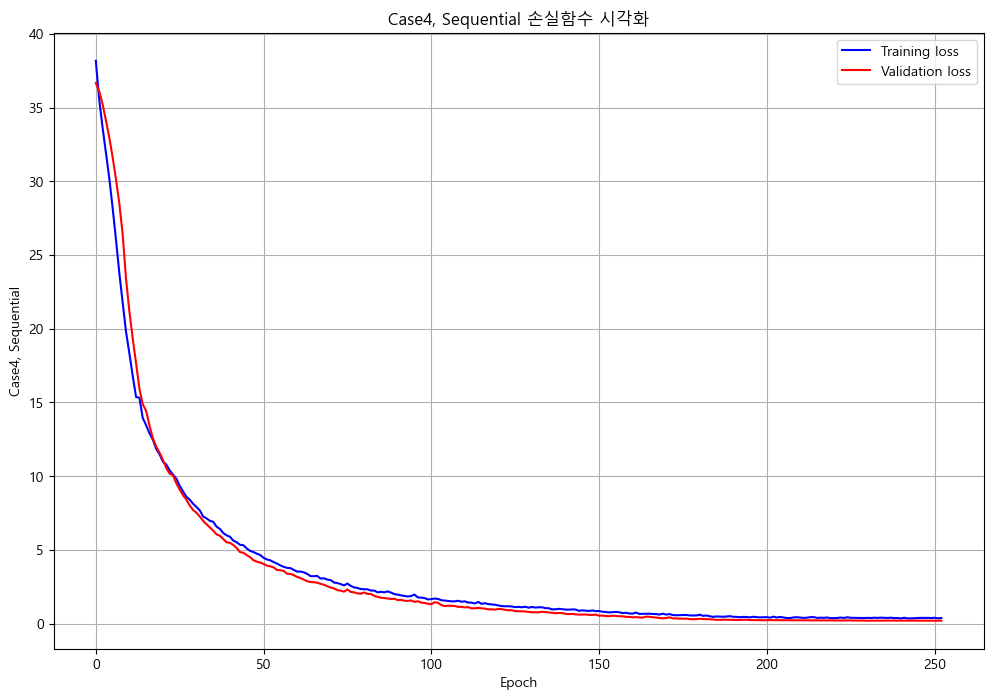

In [32]:
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.regularizers import l1_l2
    
initial_lr = 0.0005

optimizer = Adam(learning_rate=initial_lr)
# optimizer = RMSprop(learning_rate=initial_lr, clipvalue=1.0)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

case4_lstm_uni = Sequential()

case4_lstm_uni.add(LSTM(128, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005),    
                          input_shape=x_train_multi.shape[-2:]))
case4_lstm_uni.add(BatchNormalization())
case4_lstm_uni.add(Dropout(0.3))

case4_lstm_uni.add(LSTM(64, return_sequences=True,
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case4_lstm_uni.add(BatchNormalization())
case4_lstm_uni.add(Dropout(0.3))

case4_lstm_uni.add(LSTM(32, activation='relu',
                          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                          bias_regularizer=l1_l2(l1=0.005, l2=0.005)))
case4_lstm_uni.add(BatchNormalization())
case4_lstm_uni.add(Dropout(0.3))

case4_lstm_uni.add(Dense(24, activation='relu'))
case4_lstm_uni.add(Dense(12))

case4_lstm_uni.compile(optimizer=optimizer, loss='mse')

case4_lstm_uni_history = case4_lstm_uni.fit(
    train_data_multi, 
    epochs = EPOCHS, 
    steps_per_epoch = x_train_multi.shape[0] // BATCH_SIZE, 
    validation_data = val_data_multi, 
    validation_steps = x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[
        lr_restart, 
        early_stop
    ])

plot_train_history(case4_lstm_uni_history, "Case4, Sequential")

In [33]:
Y_hat_case4_uni = case4_lstm_uni.predict(x_test_multi)

Y_hat_case4_uni = np.sign(Y_hat_case4_uni) * (np.expm1(np.abs(Y_hat_case4_uni)))

case4_lstm_uni.save("./output/case4_lstm_uni.h5")

1/1 [==============================] - 1s 922ms/step


### 양방향 LSTM

Epoch 1/300
16/16 [==============================] - 9s 124ms/step - loss: 72.7710 - val_loss: 72.2544 - lr: 5.0000e-04
Epoch 2/300
16/16 [==============================] - 0s 23ms/step - loss: 68.4183 - val_loss: 69.5535 - lr: 5.0000e-04
Epoch 3/300
16/16 [==============================] - 0s 22ms/step - loss: 64.4043 - val_loss: 66.2836 - lr: 5.0000e-04
Epoch 4/300
16/16 [==============================] - 0s 23ms/step - loss: 60.3319 - val_loss: 62.7773 - lr: 5.0000e-04
Epoch 5/300
16/16 [==============================] - 0s 24ms/step - loss: 56.2898 - val_loss: 59.2500 - lr: 5.0000e-04
Epoch 6/300
16/16 [==============================] - 0s 27ms/step - loss: 52.4158 - val_loss: 55.6200 - lr: 5.0000e-04
Epoch 7/300
16/16 [==============================] - 0s 24ms/step - loss: 48.3373 - val_loss: 52.0477 - lr: 5.0000e-04
Epoch 8/300
16/16 [==============================] - 1s 59ms/step - loss: 44.2055 - val_loss: 48.5956 - lr: 5.0000e-04
Epoch 9/300
16/16 [============================

Epoch 69/300
16/16 [==============================] - 0s 25ms/step - loss: 3.7269 - val_loss: 3.4525 - lr: 2.5000e-04
Epoch 70/300
16/16 [==============================] - 0s 24ms/step - loss: 3.6661 - val_loss: 3.3226 - lr: 2.5000e-04
Epoch 71/300
16/16 [==============================] - 0s 23ms/step - loss: 3.5741 - val_loss: 3.4059 - lr: 2.5000e-04
Epoch 72/300
16/16 [==============================] - 0s 23ms/step - loss: 3.5412 - val_loss: 3.6721 - lr: 2.5000e-04
Epoch 73/300
16/16 [==============================] - 0s 25ms/step - loss: 3.5605 - val_loss: 3.1538 - lr: 2.5000e-04
Epoch 74/300
16/16 [==============================] - 0s 24ms/step - loss: 3.4630 - val_loss: 3.2108 - lr: 2.5000e-04
Epoch 75/300
16/16 [==============================] - 0s 24ms/step - loss: 3.3800 - val_loss: 3.2730 - lr: 2.5000e-04
Epoch 76/300
16/16 [==============================] - 0s 24ms/step - loss: 3.4682 - val_loss: 3.2950 - lr: 2.5000e-04
Epoch 77/300
16/16 [==============================] - 0s

16/16 [==============================] - 0s 23ms/step - loss: 2.1109 - val_loss: 1.8187 - lr: 2.5000e-04
Epoch 139/300
16/16 [==============================] - 0s 25ms/step - loss: 2.0950 - val_loss: 1.8387 - lr: 2.5000e-04
Epoch 140/300
16/16 [==============================] - 0s 26ms/step - loss: 2.0755 - val_loss: 1.8601 - lr: 2.5000e-04
Epoch 141/300
16/16 [==============================] - 0s 30ms/step - loss: 2.0365 - val_loss: 1.8071 - lr: 2.5000e-04
Epoch 142/300
16/16 [==============================] - 0s 27ms/step - loss: 2.0436 - val_loss: 1.7233 - lr: 2.5000e-04
Epoch 143/300
16/16 [==============================] - 0s 31ms/step - loss: 2.0780 - val_loss: 1.7672 - lr: 2.5000e-04
Epoch 144/300
16/16 [==============================] - 0s 26ms/step - loss: 2.0412 - val_loss: 1.7981 - lr: 2.5000e-04
Epoch 145/300
16/16 [==============================] - 0s 25ms/step - loss: 1.9851 - val_loss: 1.7679 - lr: 2.5000e-04
Epoch 146/300
16/16 [==============================] - 0s 24ms

Epoch 206/300
16/16 [==============================] - 0s 24ms/step - loss: 1.2905 - val_loss: 1.0282 - lr: 1.2500e-04
Epoch 207/300
16/16 [==============================] - 0s 24ms/step - loss: 1.2845 - val_loss: 1.0308 - lr: 1.2500e-04
Epoch 208/300
16/16 [==============================] - 0s 23ms/step - loss: 1.2055 - val_loss: 0.9976 - lr: 1.2500e-04
Epoch 209/300
16/16 [==============================] - 0s 25ms/step - loss: 1.2913 - val_loss: 1.0374 - lr: 1.2500e-04
Epoch 210/300
16/16 [==============================] - 0s 27ms/step - loss: 1.2561 - val_loss: 1.0063 - lr: 1.2500e-04
Epoch 211/300
16/16 [==============================] - 0s 23ms/step - loss: 1.2958 - val_loss: 1.0106 - lr: 1.2500e-04
Epoch 212/300
16/16 [==============================] - 0s 24ms/step - loss: 1.2966 - val_loss: 0.9960 - lr: 1.2500e-04
Epoch 213/300
16/16 [==============================] - 0s 24ms/step - loss: 1.2493 - val_loss: 0.9892 - lr: 1.2500e-04
Epoch 214/300
16/16 [===========================

Epoch 275/300
16/16 [==============================] - 0s 24ms/step - loss: 0.9488 - val_loss: 0.6735 - lr: 1.2500e-04
Epoch 276/300
16/16 [==============================] - 0s 24ms/step - loss: 0.8756 - val_loss: 0.6728 - lr: 1.2500e-04
Epoch 277/300
16/16 [==============================] - 0s 24ms/step - loss: 0.9093 - val_loss: 0.6789 - lr: 1.2500e-04
Epoch 278/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8909 - val_loss: 0.6489 - lr: 1.2500e-04
Epoch 279/300
16/16 [==============================] - 0s 23ms/step - loss: 0.9541 - val_loss: 0.6545 - lr: 1.2500e-04
Epoch 280/300
16/16 [==============================] - 0s 24ms/step - loss: 0.9180 - val_loss: 0.6635 - lr: 1.2500e-04
Epoch 281/300
16/16 [==============================] - 0s 28ms/step - loss: 0.8960 - val_loss: 0.6493 - lr: 1.2500e-04
Epoch 282/300
16/16 [==============================] - 0s 25ms/step - loss: 0.8535 - val_loss: 0.6454 - lr: 1.2500e-04
Epoch 283/300
16/16 [===========================

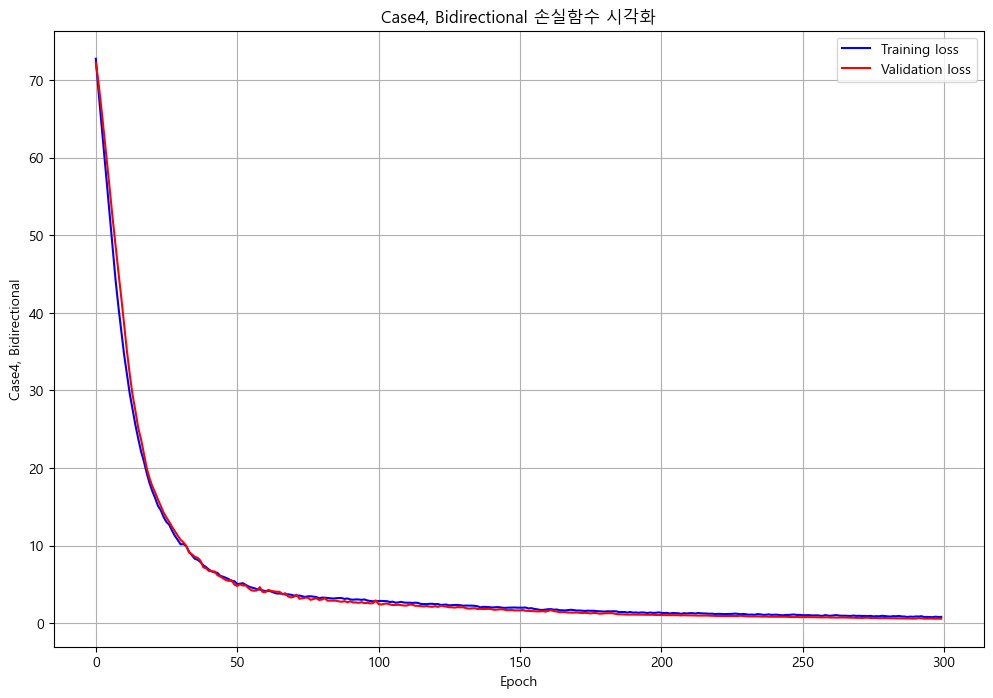

In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Attention, Concatenate
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import legacy as legacy_optimizers

# Attention 레이어 정의
def attention_layer(inputs):
    attention = Attention()([inputs, inputs])
    return Concatenate()([inputs, attention])

# 옵티마이저 설정
initial_lr = 0.0005
optimizer = legacy_optimizers.Adam(learning_rate=initial_lr)

# 학습률 재시작
lr_restart = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 정의
inputs = Input(shape=(x_train_multi.shape[1], x_train_multi.shape[2]))

x = Bidirectional(LSTM(128, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(inputs)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Bidirectional(LSTM(64, return_sequences=True,
                       kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
                       bias_regularizer=l1_l2(l1=0.005, l2=0.005)))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = attention_layer(x)

x = LSTM(32, activation='relu',
         kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
         bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)

x = Dense(24, activation='relu',
          kernel_regularizer=l1_l2(l1=0.005, l2=0.005),
          bias_regularizer=l1_l2(l1=0.005, l2=0.005))(x)
outputs = Dense(12)(x)

case4_lstm_bi = Model(inputs=inputs, outputs=outputs)

# 모델 빌드 및 컴파일
case4_lstm_bi.build(input_shape=(None, x_train_multi.shape[1], x_train_multi.shape[2]))
case4_lstm_bi.compile(optimizer=optimizer, loss='mse')

# 모델 학습
case4_lstm_bi_history = case4_lstm_bi.fit(
    train_data_multi,
    epochs=EPOCHS,
    steps_per_epoch=x_train_multi.shape[0] // BATCH_SIZE,
    validation_data=val_data_multi,
    validation_steps=x_val_multi.shape[0] // BATCH_SIZE,
    callbacks=[lr_restart, early_stop]
)

plot_train_history(case4_lstm_bi_history, "Case4, Bidirectional")

In [35]:
Y_hat_case4_bi = case4_lstm_bi.predict(x_test_multi)

Y_hat_case4_bi = np.sign(Y_hat_case4_bi) * (np.expm1(np.abs(Y_hat_case4_bi)))

case4_lstm_bi.save("./output/case4_lstm_bi.h5")

1/1 [==============================] - 2s 2s/step


# 예측값 모아보기

In [95]:
Y = np.sign(y_test_multi) * (np.expm1(np.abs(y_test_multi)))

Y = pd.DataFrame(Y)

(16, 12)

In [75]:
cases = [Y_hat_case1_uni, Y_hat_case1_bi, Y_hat_case2_uni, Y_hat_case2_bi, Y_hat_case3_uni, Y_hat_case3_bi, Y_hat_case4_uni, Y_hat_case4_bi]

total_df = pd.DataFrame()

for case in cases:
    mae_list, mse_list, rmse_list, mape_list = [], [], [], []
    
    for i in range(16):
        mae_list.append(np.mean(np.abs(Y.iloc[i] - case[i,:])))

        mse_list.append(np.mean((Y.iloc[i] - case[i,:])**2))

        rmse_list.append(np.sqrt(np.mean((Y.iloc[i] - case[i,:])**2)))

        mape_list.append(np.mean(np.abs((Y.iloc[i] - case[i,:]) / Y.iloc[i])) * 100)
    mae = np.mean(mae_list)
    mse = np.mean(mse_list)
    rmse = np.mean(rmse_list)
    mape = np.mean(mape_list)
    
    temp_df = pd.DataFrame(
            data = [mae, mse, rmse, mape],
            index = ["mae", "mse", "rmse", "mape"]
        )
    
    total_df = pd.concat([total_df, temp_df], axis = 1)
    
total_df.columns = ["Y_hat_case1_uni", "Y_hat_case1_bi", "Y_hat_case2_uni", "Y_hat_case2_bi", "Y_hat_case3_uni", "Y_hat_case3_bi", "Y_hat_case4_uni", "Y_hat_case4_bi"]

In [76]:
total_df.T

,mae,mse,rmse,mape
Y_hat_case1_uni,13.518637,275.553542,16.027839,18.062003
Y_hat_case1_bi,12.854619,253.530278,15.425810,17.085022
Y_hat_case2_uni,13.789561,396.748484,17.818110,15.483682
Y_hat_case2_bi,14.356981,410.312039,18.189286,16.342341
Y_hat_case3_uni,14.854285,332.481809,17.737440,19.959582
Y_hat_case3_bi,13.416910,276.902107,16.031445,17.787187
Y_hat_case4_uni,14.576569,456.883456,18.755305,16.694915
Y_hat_case4_bi,14.262798,354.936336,17.364281,18.096884


## 표준화 vs 로그변환

### Case1 vs Case2

In [168]:
compare1 = data[["WTIO", "SETIO", "ONI", "SOI", "D20_SCTR"]]

compare1_dts = compare1.values

# 표준화
compare1_mean = compare1_dts.mean(axis=0)
compare1_std = compare1_dts.std(axis=0)
compare1_dts_std = (compare1_dts-compare1_mean)/compare1_std

# 로그 변환
compare1_dts_log = np.sign(compare1_dts) * np.log1p(np.abs(compare1_dts))

In [169]:
X_compare1_std = compare1_dts_std[374 : 386, :]
X_compare1_std = np.reshape(X_compare1_std, (1, 12, 5))

Y_compare1_std = compare1_dts_std[387 : 399, -1]

In [134]:
X_compare1_log = compare1_dts_log[374 : 386, :]
X_compare1_log = np.reshape(X_compare1_log, (1, 12, 5))

Y_compare1_log = compare1_dts_log[387 : 399, -1]

In [124]:
from tensorflow import keras

case1_lstm_uni = keras.models.load_model('./output/case1_lstm_uni.h5')
case1_lstm_bi = keras.models.load_model('./output/case1_lstm_bi.h5')

case2_lstm_uni = keras.models.load_model('./output/case2_lstm_uni.h5')
case2_lstm_bi = keras.models.load_model('./output/case2_lstm_bi.h5')

In [142]:
# Case1 - 단방향, 양방향
Y_HAT_compare1_std_uni = case1_lstm_uni.predict(X_compare1_std)
Y_HAT_compare1_std_uni_ = Y_HAT_compare1_std_uni * compare1_std[-1] + compare1_mean[-1]

Y_HAT_compare1_std_bi = case1_lstm_bi.predict(X_compare1_std)
Y_HAT_compare1_std_bi_ = Y_HAT_compare1_std_bi * compare1_std[-1] + compare1_mean[-1]

# Case2 - 단방향, 양방향
Y_HAT_compare1_log_uni = case2_lstm_uni.predict(X_compare1_log)
Y_HAT_compare1_log_uni_ = np.sign(Y_HAT_compare1_log_uni) * (np.expm1(np.abs(Y_HAT_compare1_log_uni)))

Y_HAT_compare1_log_bi = case2_lstm_bi.predict(X_compare1_log)
Y_HAT_compare1_log_bi_ = np.sign(Y_HAT_compare1_log_bi) * (np.expm1(np.abs(Y_HAT_compare1_log_bi)))

1/1 [==============================] - 0s 26ms/step


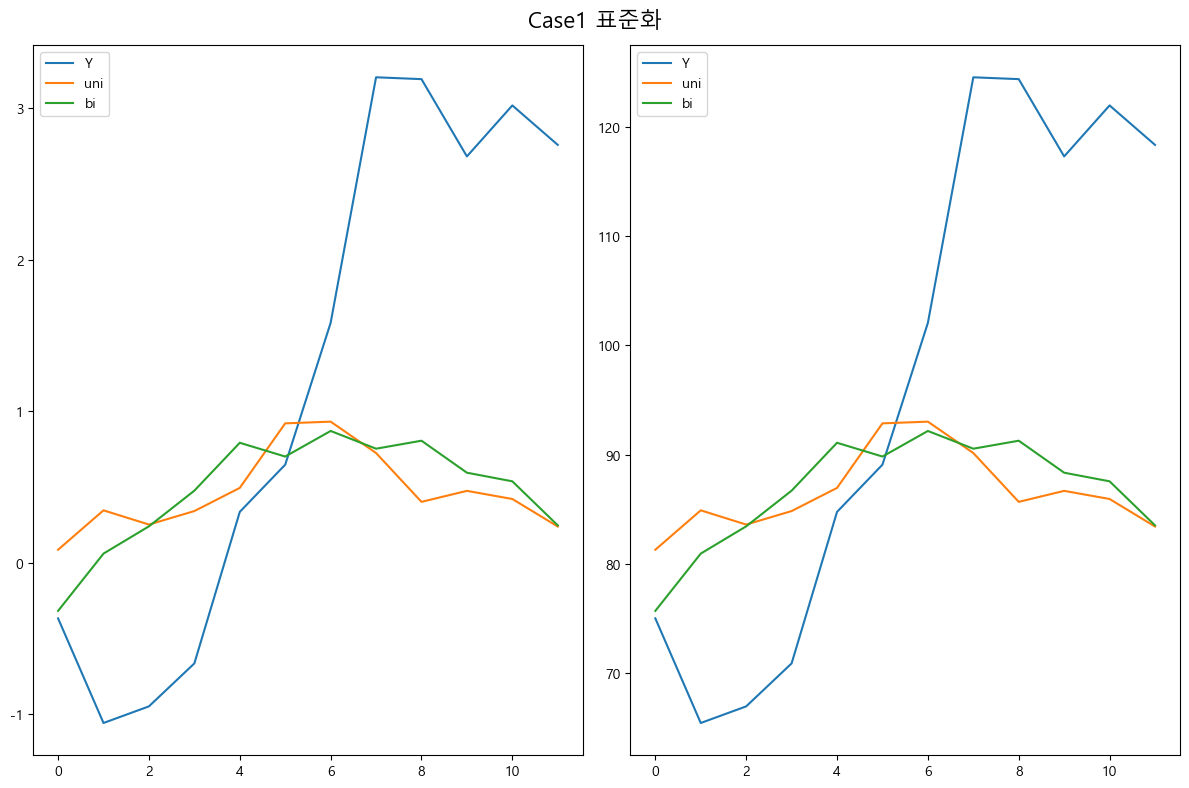

In [193]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1_std, label="Y")
ax[0].plot(Y_HAT_compare1_std_uni[0], label="uni")
ax[0].plot(Y_HAT_compare1_std_bi[0], label="bi")

ax[0].legend()

ax[1].plot(compare1_dts[387:399,-1], label="Y")
ax[1].plot(Y_HAT_compare1_std_uni_[0], label="uni")
ax[1].plot(Y_HAT_compare1_std_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case1 표준화", fontsize=16)

plt.tight_layout()

plt.show()

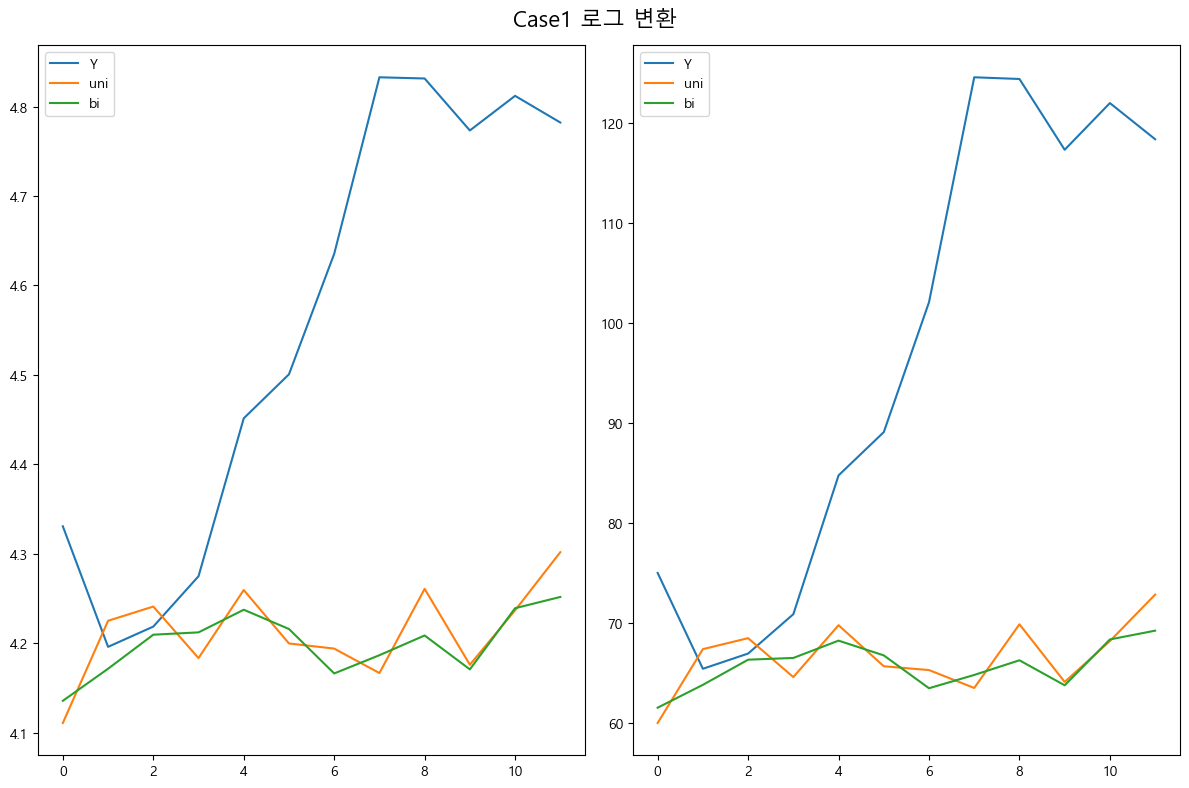

In [194]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare1_log, label="Y")
ax[0].plot(Y_HAT_compare1_log_uni[0], label="uni")
ax[0].plot(Y_HAT_compare1_log_bi[0], label="bi")

ax[0].legend()

ax[1].plot(compare1_dts[387:399,-1], label="Y")
ax[1].plot(Y_HAT_compare1_log_uni_[0], label="uni")
ax[1].plot(Y_HAT_compare1_log_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case1 로그 변환", fontsize=16)

plt.tight_layout()

plt.show()

### Case3 vs Case4

In [203]:
compare2 = data[["DMI", "ONI", "SOI", "D20_SCTR"]]

compare2_dts = compare2.values

# 표준화
compare2_mean = compare2_dts.mean(axis=0)
compare2_std = compare2_dts.std(axis=0)
compare2_dts_std = (compare2_dts-compare2_mean)/compare2_std

# 로그 변환
compare2_dts_log = np.sign(compare2_dts) * np.log1p(np.abs(compare2_dts))

In [204]:
X_compare2_std = compare2_dts_std[374 : 386, :]
X_compare2_std = np.reshape(X_compare2_std, (1, 12, 4))

Y_compare2_std = compare2_dts_std[387 : 399, -1]

In [205]:
X_compare2_log = compare2_dts_log[374 : 386, :]
X_compare2_log = np.reshape(X_compare2_log, (1, 12, 4))

Y_compare2_log = compare2_dts_log[387 : 399, -1]

In [198]:
from tensorflow import keras

case3_lstm_uni = keras.models.load_model('./output/case3_lstm_uni.h5')
case3_lstm_bi = keras.models.load_model('./output/case3_lstm_bi.h5')

case4_lstm_uni = keras.models.load_model('./output/case3_lstm_uni.h5')
case4_lstm_bi = keras.models.load_model('./output/case3_lstm_bi.h5')

In [206]:
# Case3 - 단방향, 양방향
Y_HAT_compare2_std_uni = case3_lstm_uni.predict(X_compare2_std)
Y_HAT_compare2_std_uni_ = Y_HAT_compare2_std_uni * compare2_std[-1] + compare2_mean[-1]

Y_HAT_compare2_std_bi = case3_lstm_bi.predict(X_compare2_std)
Y_HAT_compare2_std_bi_ = Y_HAT_compare2_std_bi * compare2_std[-1] + compare2_mean[-1]

# Case4 - 단방향, 양방향
Y_HAT_compare2_log_uni = case4_lstm_uni.predict(X_compare2_log)
Y_HAT_compare2_log_uni_ = np.sign(Y_HAT_compare2_log_uni) * (np.expm1(np.abs(Y_HAT_compare2_log_uni)))

Y_HAT_compare2_log_bi = case4_lstm_bi.predict(X_compare2_log)
Y_HAT_compare2_log_bi_ = np.sign(Y_HAT_compare2_log_bi) * (np.expm1(np.abs(Y_HAT_compare2_log_bi)))

1/1 [==============================] - 1s 1s/step


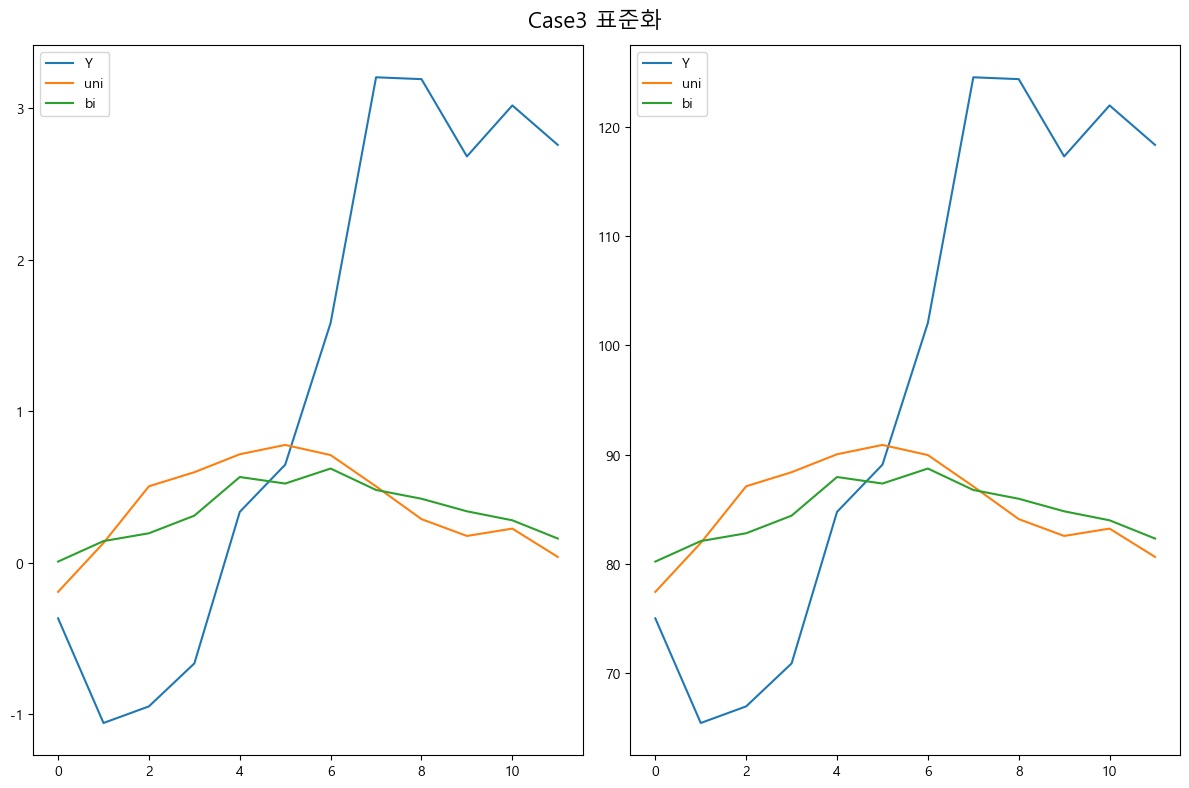

In [207]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2_std, label="Y")
ax[0].plot(Y_HAT_compare2_std_uni[0], label="uni")
ax[0].plot(Y_HAT_compare2_std_bi[0], label="bi")

ax[0].legend()

ax[1].plot(compare2_dts[387:399,-1], label="Y")
ax[1].plot(Y_HAT_compare2_std_uni_[0], label="uni")
ax[1].plot(Y_HAT_compare2_std_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case3 표준화", fontsize=16)

plt.tight_layout()

plt.show()

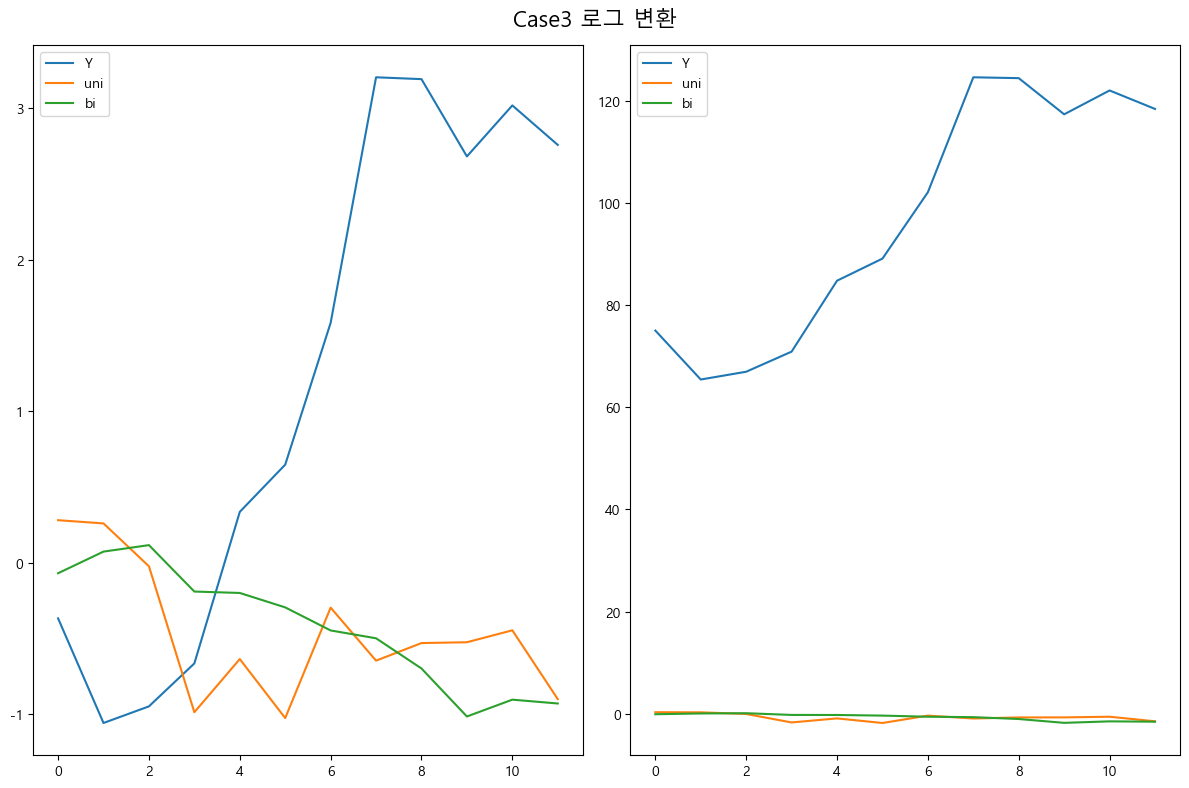

In [208]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].plot(Y_compare2_std, label="Y")
ax[0].plot(Y_HAT_compare2_log_uni[0], label="uni")
ax[0].plot(Y_HAT_compare2_log_bi[0], label="bi")

ax[0].legend()

ax[1].plot(compare2_dts[387:399,-1], label="Y")
ax[1].plot(Y_HAT_compare2_log_uni_[0], label="uni")
ax[1].plot(Y_HAT_compare2_log_bi_[0], label="bi")

ax[1].legend()

plt.suptitle("Case3 로그 변환", fontsize=16)

plt.tight_layout()

plt.show()

In [209]:
Y_HAT_compare2_log_uni_

array([[ 0.32394767,  0.29613322, -0.02366922, -1.6828678 , -0.88873553,
        -1.7881658 , -0.34515044, -0.9087745 , -0.6993787 , -0.6902803 ,
        -0.5623369 , -1.4602814 ]], dtype=float32)

## WTIO, SETIO vs DMI

### Case1 vs Case3

### Case2 vs Case4